<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Sun Feb 25 11:37:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:A8:00.0 Off |                    0 |
| N/A   48C    P0              55W / 350W |      4MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [8]:
%%time

######### Generating SINN training data by solving SDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad



###### Parameters 
mag=1              # Magnitude of the coupling
beta=1             # Inverse temperature 
alpha=1            
gamma=1            # Anharmonic potential U(x)=alpha/2* x^2  + gamma/4* x^4
N=100              # Total number of oscillators in the chain 
N_mid=int(N/2)     # Coordinate of the center CG-oscillator 
dt=0.01 
delta_t=0.5
batch = 400
sec_length = 400

Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]



# (q49,q50)
q49_store = np.zeros([t_store.size+1,batch])    
q50_store = np.zeros([t_store.size+1,batch])

q=np.zeros((1,length)) 

p1=np.zeros((N,batch))
q1=np.zeros((N,batch))
p0=np.zeros((N,batch))
q0=np.zeros((N,batch))

# solve SDE

j=1
for i in range(1,length):
    q1=q0+dt*(p0-np.roll(p0,1,axis=0))
    p1=(1-mag*dt)*p0+dt*alpha*(np.roll(q0,-1,axis=0)-q0)+dt*gamma*(np.roll(q0,-1,axis=0)**3-q0**3)+np.sqrt(2*dt*gamma/beta)*np.random.randn(N,batch)
    if i % gap ==0:        
        q49_store[j,:]= np.sum(q1[0:N_mid-1,:], axis=0)
        q50_store[j,:]= np.sum(q1[0:N_mid,:], axis=0)
        j=j+1
    p0=p1
    q0=q1
                                
Toss=int(t_store.size/4)
q49_store=q49_store[Toss:-1,:] 
q50_store=q50_store[Toss:-1,:] 

1000.0
CPU times: user 9min 10s, sys: 6.08 ms, total: 9min 10s
Wall time: 9min 11s


Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{49}$ and $q_{50}$')

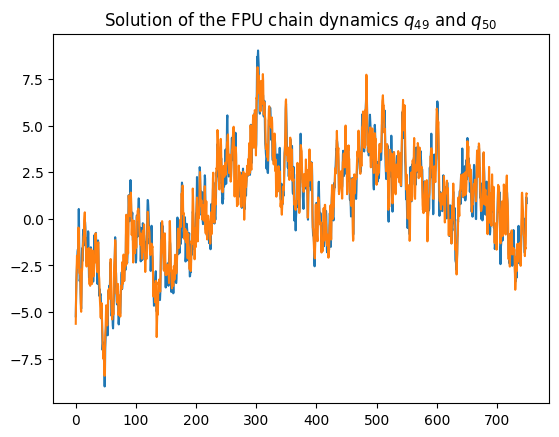

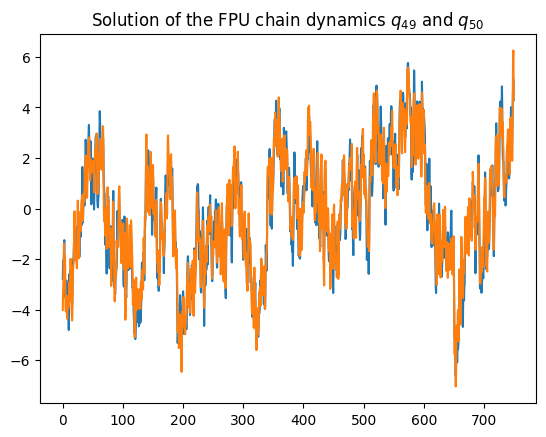

In [9]:
plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,0])
plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,0])
plt.title(r"Solution of the FPU chain dynamics $q_{49}$ and $q_{50}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,1])
plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,1])
plt.title(r"Solution of the FPU chain dynamics $q_{49}$ and $q_{50}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


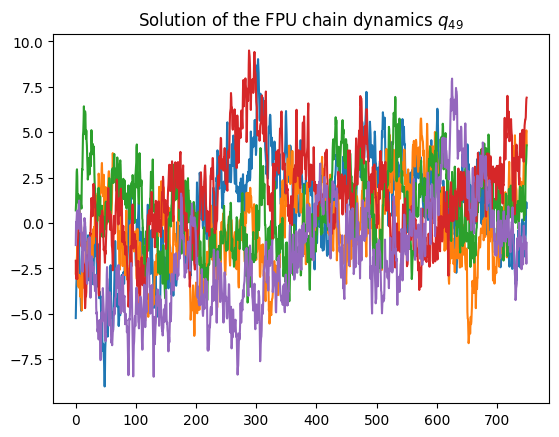

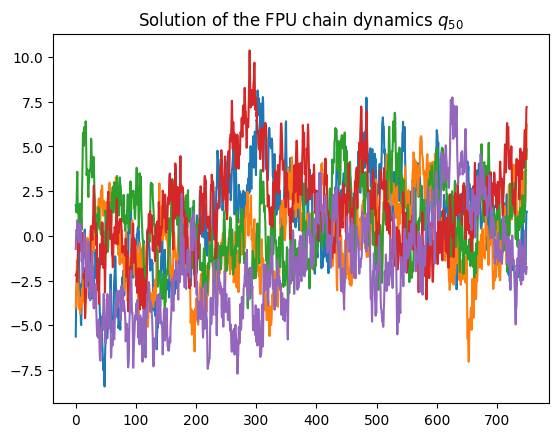

In [10]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{49}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{50}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj49 = q49_store[0:sec_length,:]
Traj50 = q50_store[0:sec_length,:]
print(ini.shape, Traj49.shape, Traj50.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj49
Traj[:,:,1] = Traj50
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [11]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [12]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


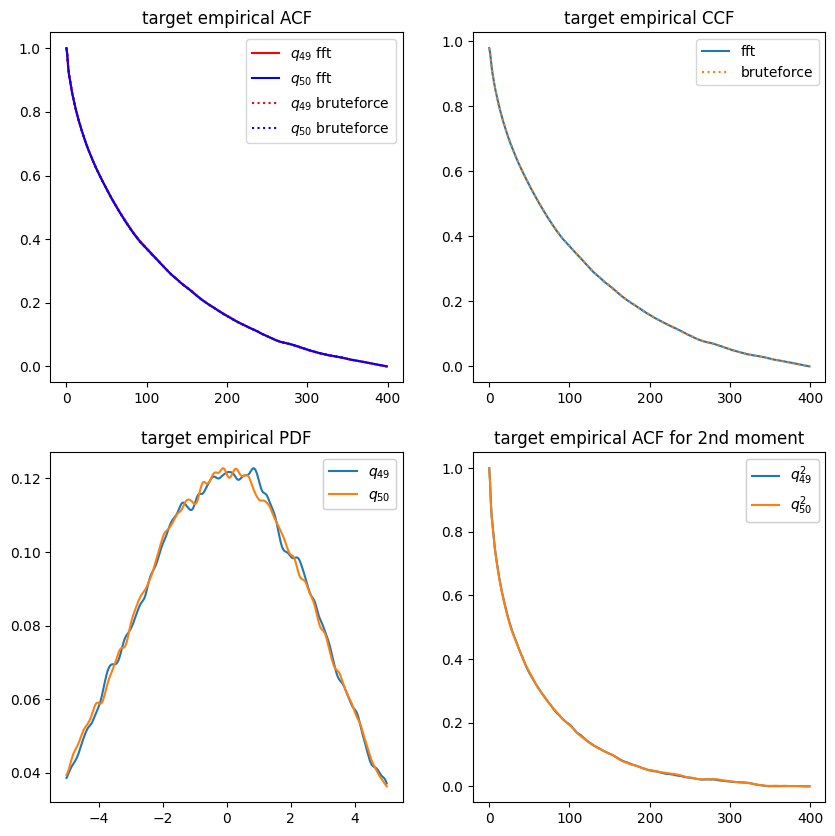

In [13]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{49}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{50}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{49}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{50}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(x_grid,loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{49}$',r'$q_{50}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{49}^2$',r'$q_{50}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

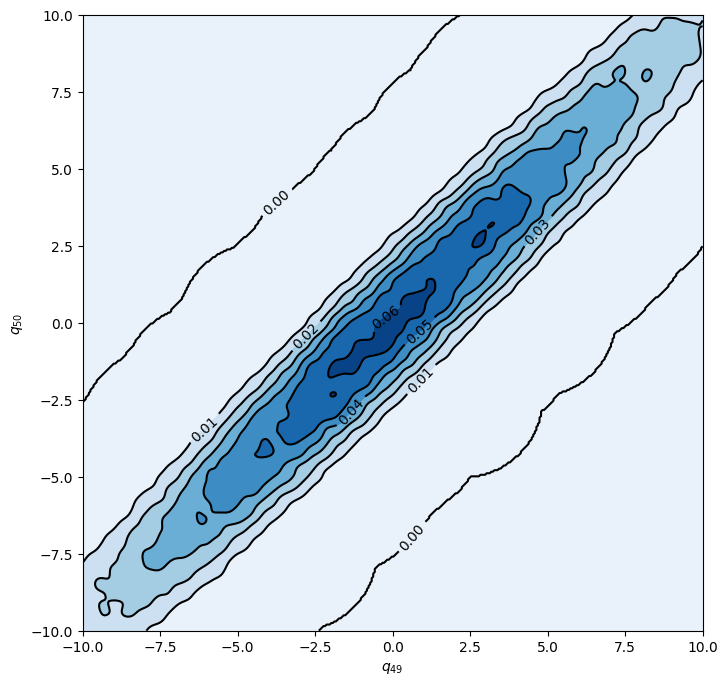

In [14]:
xmin, xmax = -10, 10
ymin, ymax = -10, 10

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{49}$')
ax.set_ylabel(r'$q_{50}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

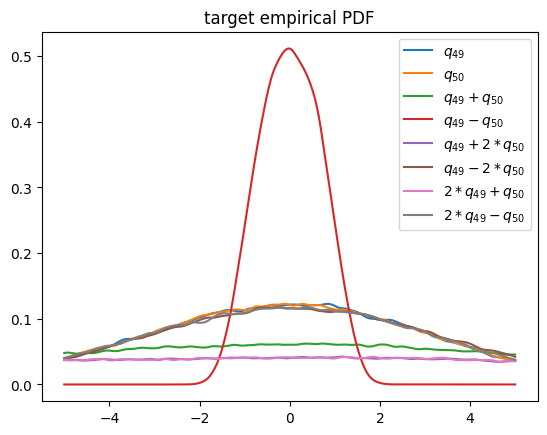

In [15]:
x_grid=-np.linspace(-5,5,num=sec_length)
# x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(x_grid, loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{49}$')
plt.plot(x_grid, loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{50}$')
plt.plot(x_grid, loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{49}+q_{50}$')
plt.plot(x_grid, loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{49}-q_{50}$')
plt.plot(x_grid, loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{49}+2*q_{50}$')
plt.plot(x_grid, loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{49}-2*q_{50}$')
plt.plot(x_grid, loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{49}+q_{50}$')
plt.plot(x_grid, loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{49}-q_{50}$')
plt.legend()
plt.title('target empirical PDF')

In [16]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2


    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <=0.0005 and loss_val <=0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <=0.0005 and loss_val <=0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(.2).float()
        self.x_pdf2_s = torch.tensor(.2).float()
        self.x_acf2_s = torch.tensor(.2).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [17]:
### Defining SINN model
net = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension

In [18]:
model = Model(net=net)

In [19]:
model_type = 1

In [20]:
model.train()

[0]-th step loss: 0.8418, 0.8223, acf: 0.09777, ccf: 0.10007, pdf: 0.29316, pdf2: 0.28974, acf2: 0.04153
[50]-th step loss: 0.0976, 0.0844, acf: 0.02697, ccf: 0.02719, pdf: 0.01698, pdf2: 0.01086, acf2: 0.00238
[100]-th step loss: 0.3844, 0.0982, acf: 0.02074, ccf: 0.02097, pdf: 0.03031, pdf2: 0.02315, acf2: 0.00300
[150]-th step loss: 0.1030, 0.0841, acf: 0.03308, ccf: 0.03332, pdf: 0.00789, pdf2: 0.00592, acf2: 0.00387
[200]-th step loss: 0.0381, 0.0723, acf: 0.03044, ccf: 0.03119, pdf: 0.00605, pdf2: 0.00235, acf2: 0.00230
[250]-th step loss: 0.0598, 0.0605, acf: 0.01914, ccf: 0.01947, pdf: 0.00829, pdf2: 0.01160, acf2: 0.00204
[300]-th step loss: 0.0353, 0.0368, acf: 0.01183, ccf: 0.01180, pdf: 0.00830, pdf2: 0.00406, acf2: 0.00082
[350]-th step loss: 0.0515, 0.0447, acf: 0.01550, ccf: 0.01687, pdf: 0.00829, pdf2: 0.00373, acf2: 0.00027
[400]-th step loss: 0.0366, 0.0362, acf: 0.01161, ccf: 0.01152, pdf: 0.00829, pdf2: 0.00439, acf2: 0.00034
[450]-th step loss: 0.2449, 0.1925, acf:

[3850]-th step loss: 0.0773, 0.0803, acf: 0.01361, ccf: 0.01354, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00010
[3900]-th step loss: 0.0869, 0.0783, acf: 0.01256, ccf: 0.01249, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00019
[3950]-th step loss: 0.0878, 0.0859, acf: 0.01643, ccf: 0.01636, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00008
[4000]-th step loss: 0.0853, 0.0804, acf: 0.01367, ccf: 0.01360, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00009
[4050]-th step loss: 0.0774, 0.0821, acf: 0.01455, ccf: 0.01447, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00009
[4100]-th step loss: 0.0843, 0.0824, acf: 0.01467, ccf: 0.01460, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00008
[4150]-th step loss: 0.0738, 0.0753, acf: 0.01094, ccf: 0.01087, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00041
[4200]-th step loss: 0.0738, 0.0737, acf: 0.01009, ccf: 0.01003, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00058
[4250]-th step loss: 0.0841, 0.0799, acf: 0.01343, ccf: 0.01336, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00009
[4300]-th step loss: 0.0868,

[7650]-th step loss: 0.0876, 0.0491, acf: 0.00737, ccf: 0.00747, pdf: 0.00703, pdf2: 0.02581, acf2: 0.00137
[7700]-th step loss: 0.0363, 0.0360, acf: 0.00045, ccf: 0.00030, pdf: 0.00599, pdf2: 0.02444, acf2: 0.00479
[7750]-th step loss: 0.0357, 0.0352, acf: 0.00088, ccf: 0.00081, pdf: 0.00681, pdf2: 0.02500, acf2: 0.00167
[7800]-th step loss: 0.0366, 0.0389, acf: 0.00122, ccf: 0.00110, pdf: 0.00655, pdf2: 0.02499, acf2: 0.00508
[7850]-th step loss: 0.0493, 0.0438, acf: 0.00082, ccf: 0.00069, pdf: 0.00719, pdf2: 0.02903, acf2: 0.00611
[7900]-th step loss: 0.0422, 0.0402, acf: 0.00044, ccf: 0.00033, pdf: 0.00689, pdf2: 0.02915, acf2: 0.00344
[7950]-th step loss: 0.0609, 0.0429, acf: 0.00120, ccf: 0.00111, pdf: 0.00682, pdf2: 0.02986, acf2: 0.00386
[8000]-th step loss: 0.2056, 0.0886, acf: 0.00405, ccf: 0.00234, pdf: 0.00808, pdf2: 0.03400, acf2: 0.04010
[8050]-th step loss: 0.0561, 0.0530, acf: 0.00174, ccf: 0.00167, pdf: 0.00718, pdf2: 0.03397, acf2: 0.00844
[8100]-th step loss: 0.0563,

[11450]-th step loss: 0.0008, 0.0009, acf: 0.00017, ccf: 0.00015, pdf: 0.00006, pdf2: 0.00012, acf2: 0.00041
[11500]-th step loss: 0.0009, 0.0008, acf: 0.00023, ccf: 0.00020, pdf: 0.00008, pdf2: 0.00014, acf2: 0.00016
[11550]-th step loss: 0.0005, 0.0005, acf: 0.00010, ccf: 0.00009, pdf: 0.00009, pdf2: 0.00004, acf2: 0.00020
[11600]-th step loss: 0.0007, 0.0005, acf: 0.00004, ccf: 0.00004, pdf: 0.00008, pdf2: 0.00005, acf2: 0.00027
[11650]-th step loss: 0.0017, 0.0014, acf: 0.00014, ccf: 0.00014, pdf: 0.00003, pdf2: 0.00003, acf2: 0.00109
[11700]-th step loss: 0.0009, 0.0037, acf: 0.00028, ccf: 0.00029, pdf: 0.00034, pdf2: 0.00032, acf2: 0.00249
[11750]-th step loss: 0.0005, 0.0005, acf: 0.00009, ccf: 0.00011, pdf: 0.00009, pdf2: 0.00009, acf2: 0.00013
[11800]-th step loss: 0.0006, 0.0025, acf: 0.00046, ccf: 0.00046, pdf: 0.00010, pdf2: 0.00004, acf2: 0.00141
[11850]-th step loss: 0.0005, 0.0003, acf: 0.00005, ccf: 0.00006, pdf: 0.00005, pdf2: 0.00003, acf2: 0.00008
[11900]-th step los

In [21]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [22]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [23]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [24]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

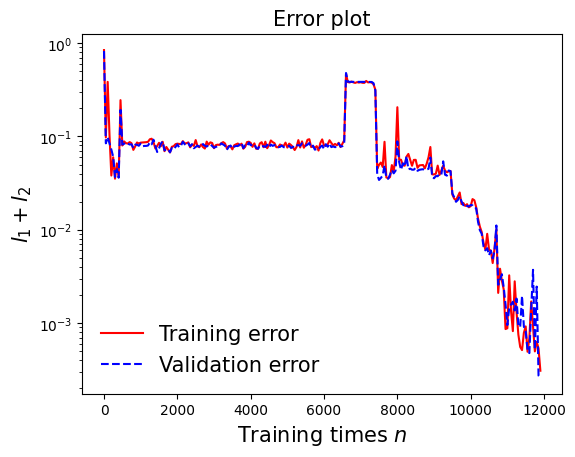

In [25]:
draw_loss(model)

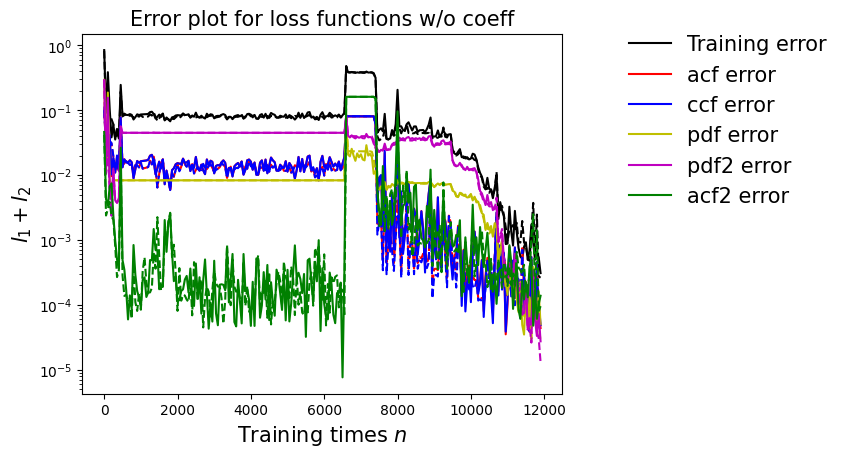

In [26]:
draw_errors(model)

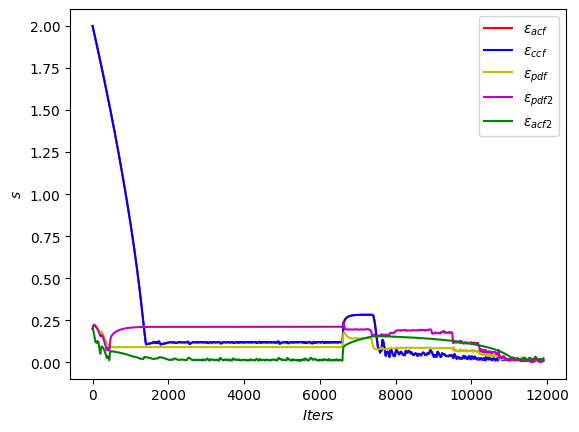

In [27]:
draw_adaptive_w(model)

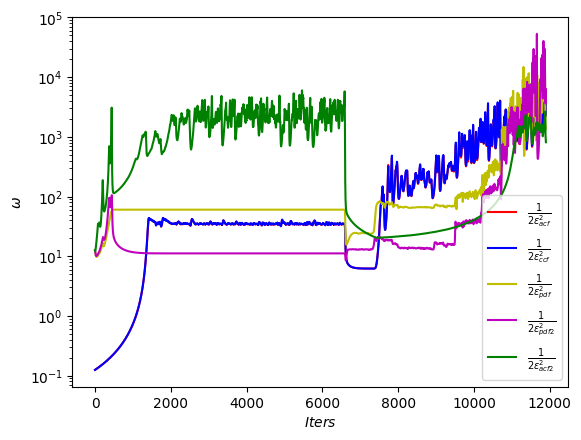

In [28]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [29]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$\tilde{q}_1(t)$ and $\tilde{q}_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [30]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [31]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{49}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{49}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{50}$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{49}+q_{50}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{49}-q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{49}+q_{50}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{49}-q_{50}$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{49}+2q_{50}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{49}-2q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{49}+2\tilde{q}_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{49}-2\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{49}+\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{49}-\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{49}+\tilde{q}_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{49}-\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [32]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{49}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{50}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [33]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{49}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q49_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{49}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{50}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q50_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{50}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [34]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{49}(t)$',fontsize=15)
    plt.ylabel(r'$q_{50}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{49}(t)$',fontsize=15)
    plt.ylabel(r'$q_{50}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [35]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{49}$')
    plt.ylabel(r'$q_{50}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{49}$')
    ax.set_ylabel(r'$q_{50}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{49}$')
    ax.set_ylabel(r'$q_{50}$')

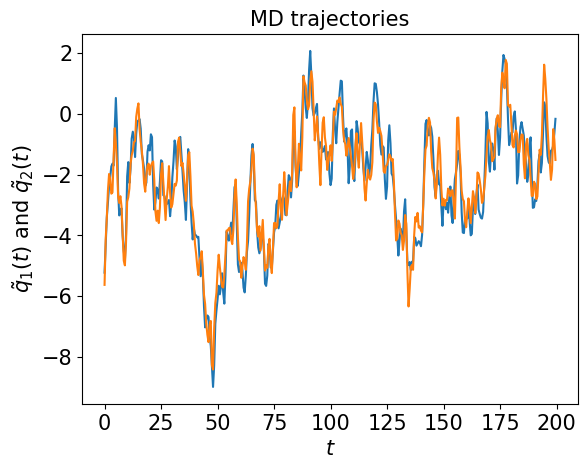

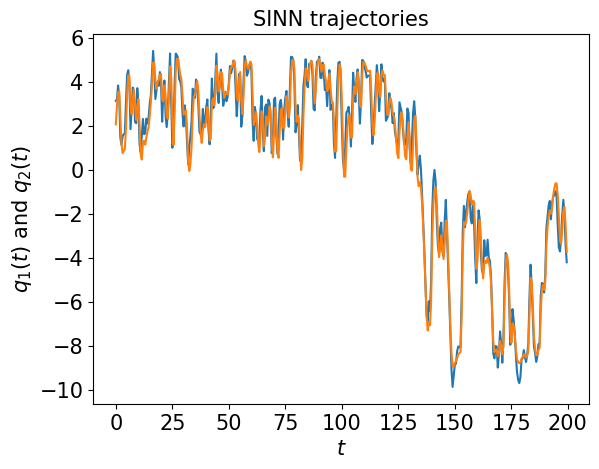

In [36]:
test1(model)

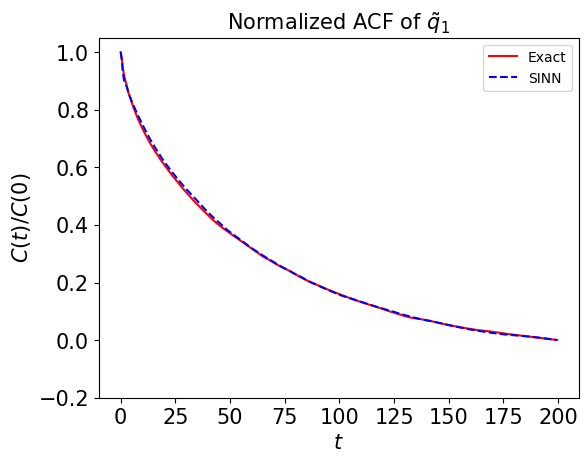

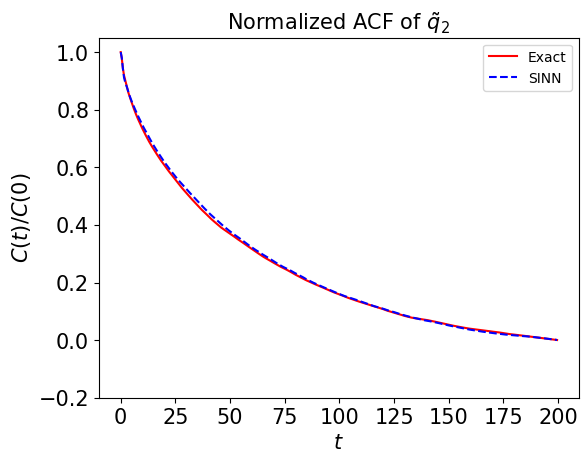

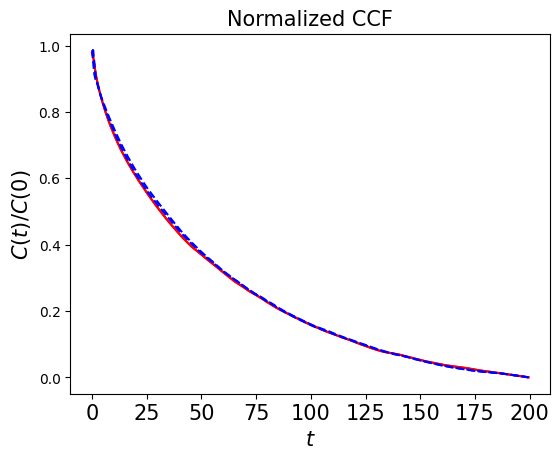

In [37]:
test2(model)

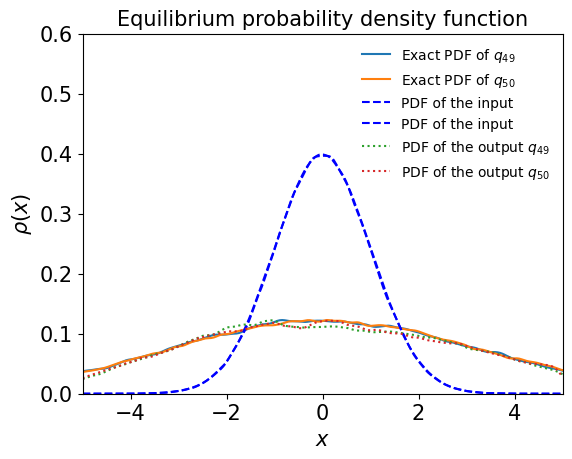

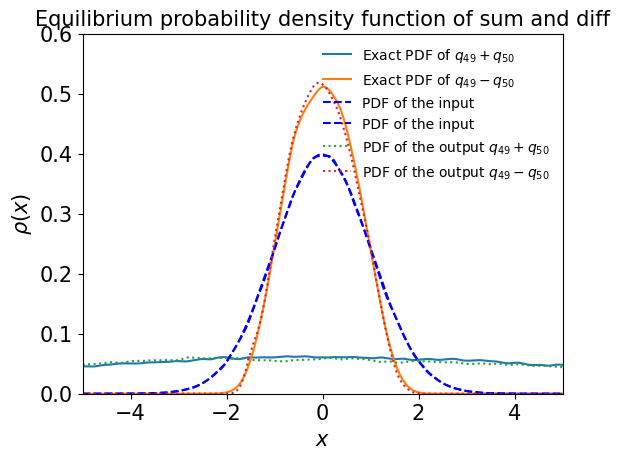

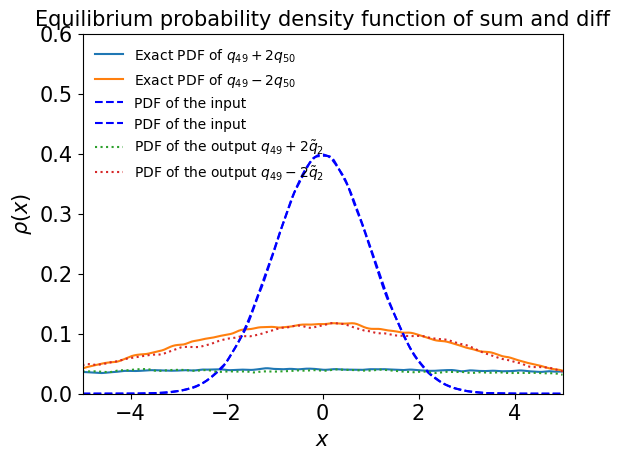

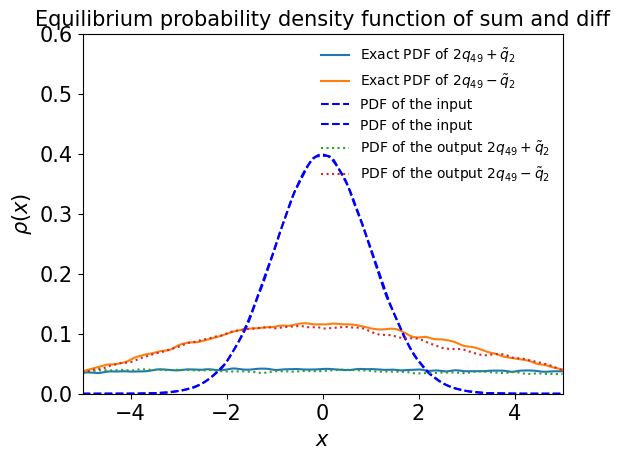

In [38]:
test3(model)

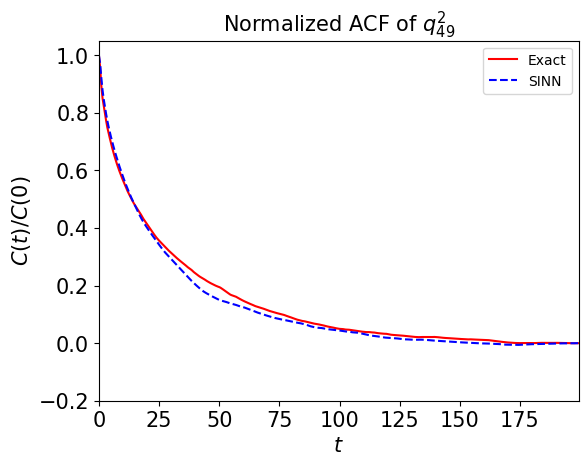

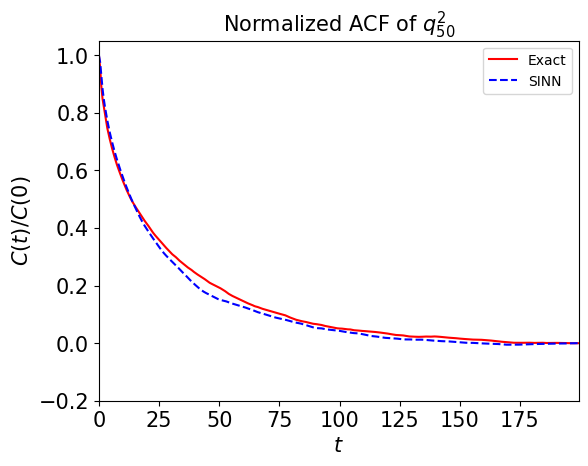

In [39]:
test4(model)

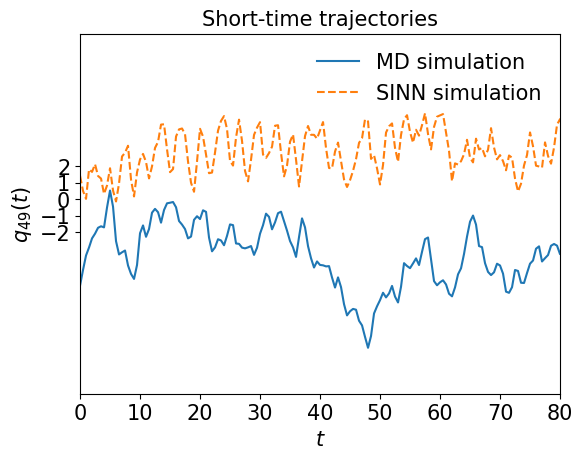

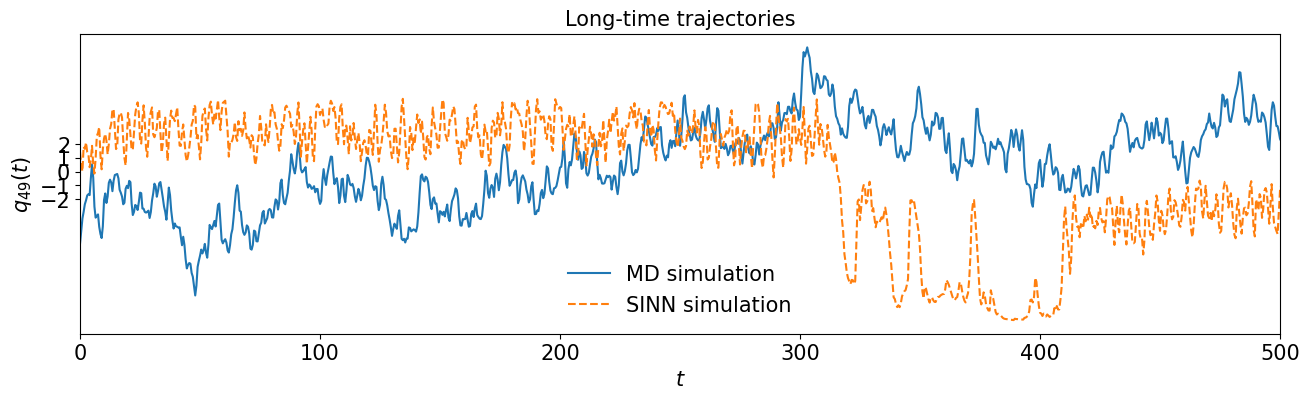

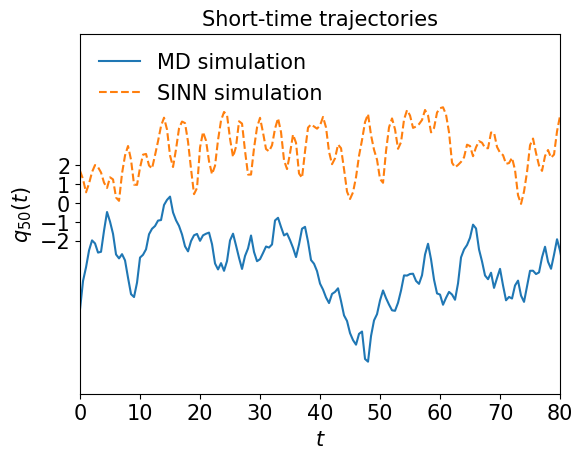

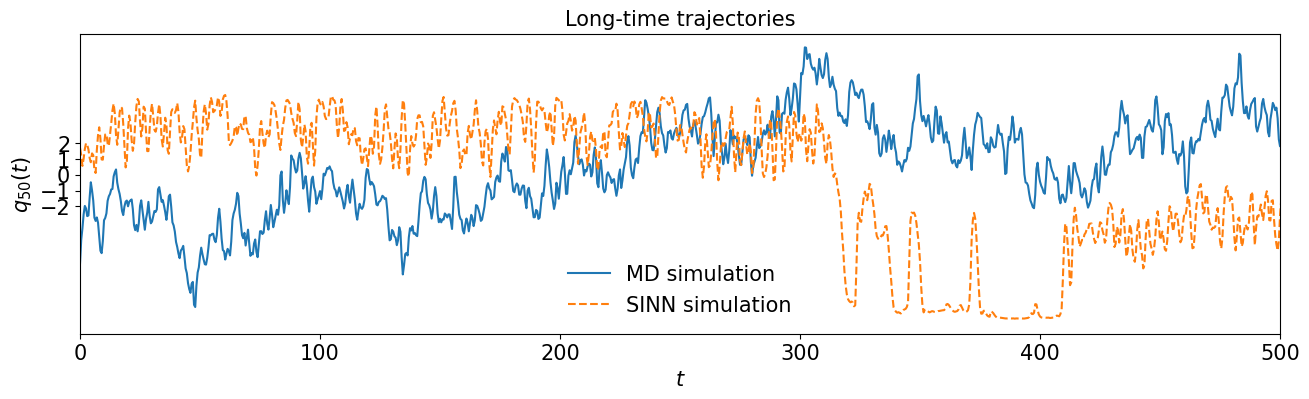

In [40]:
test5(model)

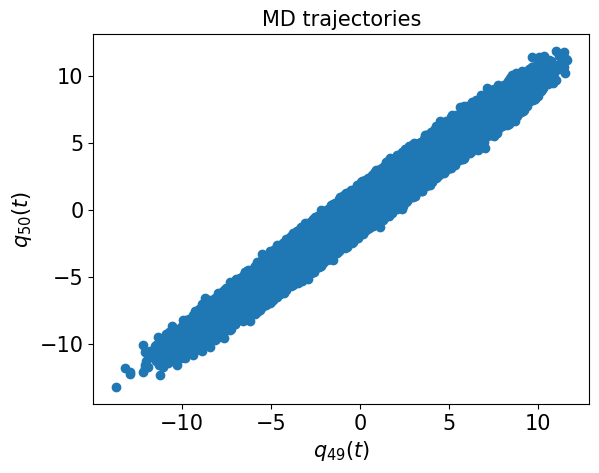

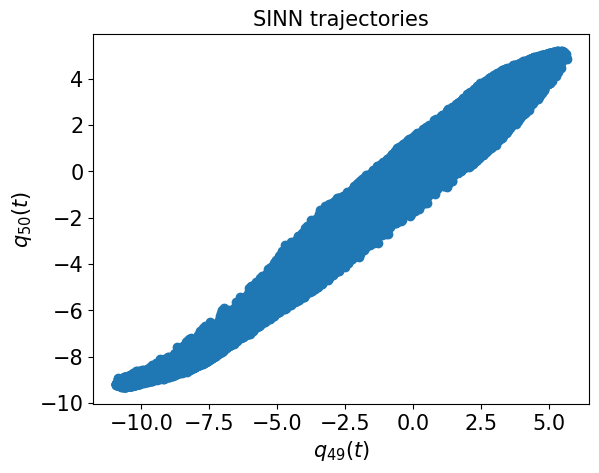

In [41]:
test6(model)

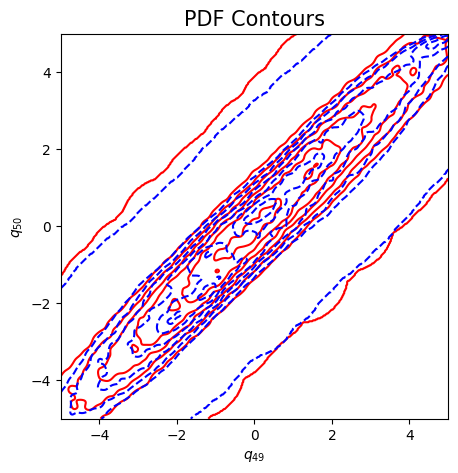

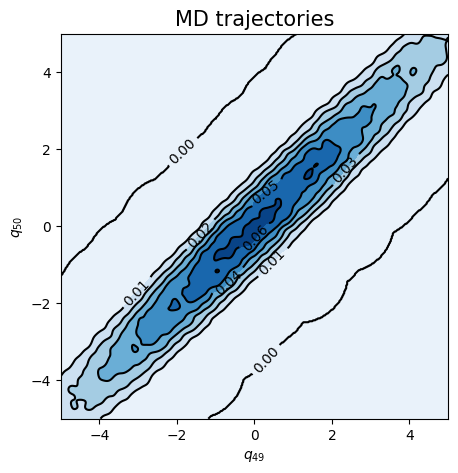

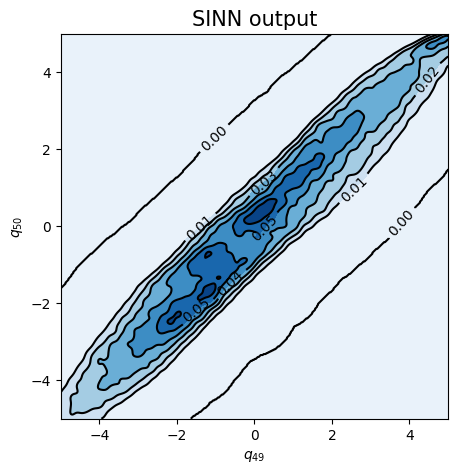

In [42]:
test7(model)

In [43]:
### Defining SINN model
net1 = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.8655, 0.8500, acf: 0.09718, ccf: 0.12872, pdf: 0.29312, pdf2: 0.28983, acf2: 0.04111
[50]-th step loss: 0.3406, 0.3392, acf: 0.05748, ccf: 0.23355, pdf: 0.01117, pdf2: 0.01748, acf2: 0.01950
[100]-th step loss: 0.2109, 0.2079, acf: 0.04329, ccf: 0.10535, pdf: 0.03220, pdf2: 0.01828, acf2: 0.00877
[150]-th step loss: 0.0530, 0.0695, acf: 0.01110, ccf: 0.04329, pdf: 0.00567, pdf2: 0.00764, acf2: 0.00176
[200]-th step loss: 0.3178, 0.3131, acf: 0.05765, ccf: 0.22030, pdf: 0.00731, pdf2: 0.01530, acf2: 0.01249
[250]-th step loss: 0.2819, 0.2663, acf: 0.02718, ccf: 0.22593, pdf: 0.00345, pdf2: 0.00845, acf2: 0.00126
[300]-th step loss: 0.3708, 0.3679, acf: 0.05188, ccf: 0.24799, pdf: 0.00622, pdf2: 0.04861, acf2: 0.01323
[350]-th step loss: 0.3822, 0.3839, acf: 0.01407, ccf: 0.35329, pdf: 0.00405, pdf2: 0.01046, acf2: 0.00199
[400]-th step loss: 0.3349, 0.3389, acf: 0.02602, ccf: 0.30087, pdf: 0.00294, pdf2: 0.00809, acf2: 0.00100
[450]-th step loss: 0.3454, 0.3603, acf:

[3850]-th step loss: 0.4788, 0.4643, acf: 0.00285, ccf: 0.38868, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00486
[3900]-th step loss: 0.4434, 0.4452, acf: 0.00509, ccf: 0.36941, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00275
[3950]-th step loss: 0.4838, 0.4935, acf: 0.00105, ccf: 0.41627, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00825
[4000]-th step loss: 0.4775, 0.4933, acf: 0.00111, ccf: 0.41625, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00805
[4050]-th step loss: 0.4464, 0.4264, acf: 0.00805, ccf: 0.34922, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00120
[4100]-th step loss: 0.4902, 0.4455, acf: 0.00518, ccf: 0.36976, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00260
[4150]-th step loss: 0.4791, 0.4638, acf: 0.00296, ccf: 0.38820, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00471
[4200]-th step loss: 0.4803, 0.4542, acf: 0.00397, ccf: 0.37864, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00362
[4250]-th step loss: 0.4720, 0.4530, acf: 0.00414, ccf: 0.37748, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00346
[4300]-th step loss: 0.4823,

[7650]-th step loss: 0.4106, 0.4255, acf: 0.01174, ccf: 0.34478, pdf: 0.00829, pdf2: 0.05964, acf2: 0.00106
[7700]-th step loss: 0.4102, 0.4255, acf: 0.00845, ccf: 0.34810, pdf: 0.00829, pdf2: 0.05964, acf2: 0.00100
[7750]-th step loss: 0.4235, 0.4214, acf: 0.00907, ccf: 0.34356, pdf: 0.00829, pdf2: 0.05967, acf2: 0.00080
[7800]-th step loss: 0.4254, 0.4257, acf: 0.00780, ccf: 0.34865, pdf: 0.00829, pdf2: 0.05964, acf2: 0.00128
[7850]-th step loss: 0.4094, 0.4086, acf: 0.01122, ccf: 0.32906, pdf: 0.00829, pdf2: 0.05964, acf2: 0.00041
[7900]-th step loss: 0.4053, 0.4115, acf: 0.01000, ccf: 0.33301, pdf: 0.00829, pdf2: 0.05964, acf2: 0.00056
[7950]-th step loss: 0.3988, 0.4077, acf: 0.01059, ccf: 0.32875, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00044
[8000]-th step loss: 0.3891, 0.3875, acf: 0.01188, ccf: 0.30744, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00026
[8050]-th step loss: 0.3565, 0.3720, acf: 0.01038, ccf: 0.29322, pdf: 0.00829, pdf2: 0.05963, acf2: 0.00048
[8100]-th step loss: 0.4177,

[11450]-th step loss: 0.0857, 0.0832, acf: 0.00026, ccf: 0.00024, pdf: 0.00829, pdf2: 0.05810, acf2: 0.01628
[11500]-th step loss: 0.0799, 0.0799, acf: 0.00006, ccf: 0.00006, pdf: 0.00829, pdf2: 0.05790, acf2: 0.01359
[11550]-th step loss: 0.0843, 0.0794, acf: 0.00015, ccf: 0.00014, pdf: 0.00829, pdf2: 0.05852, acf2: 0.01228
[11600]-th step loss: 0.0819, 0.0869, acf: 0.00038, ccf: 0.00039, pdf: 0.00829, pdf2: 0.05846, acf2: 0.01937
[11650]-th step loss: 0.0801, 0.0801, acf: 0.00004, ccf: 0.00003, pdf: 0.00829, pdf2: 0.05778, acf2: 0.01393
[11700]-th step loss: 0.0814, 0.0810, acf: 0.00002, ccf: 0.00002, pdf: 0.00829, pdf2: 0.05790, acf2: 0.01479
[11750]-th step loss: 0.0820, 0.0793, acf: 0.00011, ccf: 0.00010, pdf: 0.00829, pdf2: 0.05795, acf2: 0.01286
[11800]-th step loss: 0.0827, 0.0798, acf: 0.00007, ccf: 0.00006, pdf: 0.00829, pdf2: 0.05800, acf2: 0.01338
[11850]-th step loss: 0.0878, 0.0797, acf: 0.00008, ccf: 0.00008, pdf: 0.00829, pdf2: 0.05803, acf2: 0.01326
[11900]-th step los

[15250]-th step loss: 0.0807, 0.0797, acf: 0.00015, ccf: 0.00014, pdf: 0.00829, pdf2: 0.05886, acf2: 0.01228
[15300]-th step loss: 0.0828, 0.0821, acf: 0.00003, ccf: 0.00003, pdf: 0.00829, pdf2: 0.05885, acf2: 0.01488
[15350]-th step loss: 0.0857, 0.0819, acf: 0.00003, ccf: 0.00003, pdf: 0.00829, pdf2: 0.05884, acf2: 0.01467
[15400]-th step loss: 0.0852, 0.0842, acf: 0.00016, ccf: 0.00016, pdf: 0.00829, pdf2: 0.05907, acf2: 0.01654
[15450]-th step loss: 0.0800, 0.0796, acf: 0.00017, ccf: 0.00016, pdf: 0.00829, pdf2: 0.05886, acf2: 0.01210
[15500]-th step loss: 0.0892, 0.0807, acf: 0.00015, ccf: 0.00015, pdf: 0.00829, pdf2: 0.05891, acf2: 0.01321
[15550]-th step loss: 0.0868, 0.0857, acf: 0.00019, ccf: 0.00019, pdf: 0.00829, pdf2: 0.05895, acf2: 0.01806
[15600]-th step loss: 0.0803, 0.0795, acf: 0.00016, ccf: 0.00015, pdf: 0.00829, pdf2: 0.05874, acf2: 0.01218
[15650]-th step loss: 0.0798, 0.0789, acf: 0.00029, ccf: 0.00028, pdf: 0.00829, pdf2: 0.05881, acf2: 0.01118
[15700]-th step los

[19050]-th step loss: 0.0789, 0.0779, acf: 0.00014, ccf: 0.00013, pdf: 0.00829, pdf2: 0.05677, acf2: 0.01251
[19100]-th step loss: 0.0838, 0.0812, acf: 0.00004, ccf: 0.00004, pdf: 0.00829, pdf2: 0.05799, acf2: 0.01481
[19150]-th step loss: 0.0780, 0.0812, acf: 0.00008, ccf: 0.00009, pdf: 0.00829, pdf2: 0.05619, acf2: 0.01656
[19200]-th step loss: 0.0824, 0.0802, acf: 0.00002, ccf: 0.00002, pdf: 0.00829, pdf2: 0.05685, acf2: 0.01501
[19250]-th step loss: 0.0803, 0.0774, acf: 0.00011, ccf: 0.00010, pdf: 0.00829, pdf2: 0.05616, acf2: 0.01274
[19300]-th step loss: 0.0834, 0.0770, acf: 0.00025, ccf: 0.00024, pdf: 0.00829, pdf2: 0.05657, acf2: 0.01160
[19350]-th step loss: 0.0811, 0.0792, acf: 0.00001, ccf: 0.00001, pdf: 0.00829, pdf2: 0.05604, acf2: 0.01485
[19400]-th step loss: 0.0797, 0.0778, acf: 0.00010, ccf: 0.00009, pdf: 0.00829, pdf2: 0.05637, acf2: 0.01298
[19450]-th step loss: 0.0785, 0.0780, acf: 0.00003, ccf: 0.00003, pdf: 0.00829, pdf2: 0.05573, acf2: 0.01387
[19500]-th step los

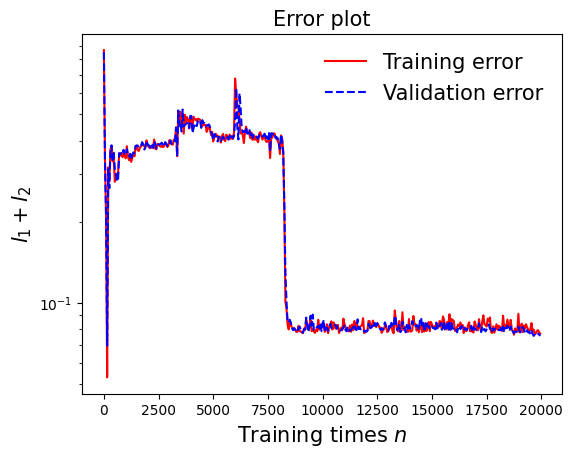

In [44]:
draw_loss(model1)

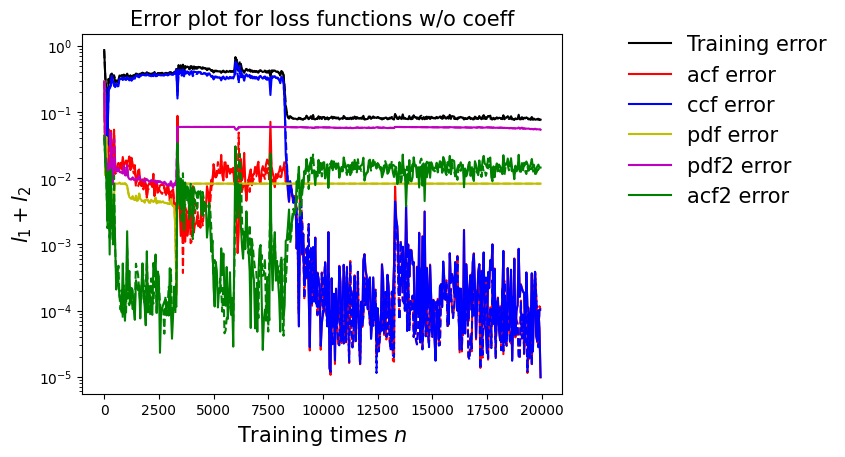

In [45]:
draw_errors(model1)

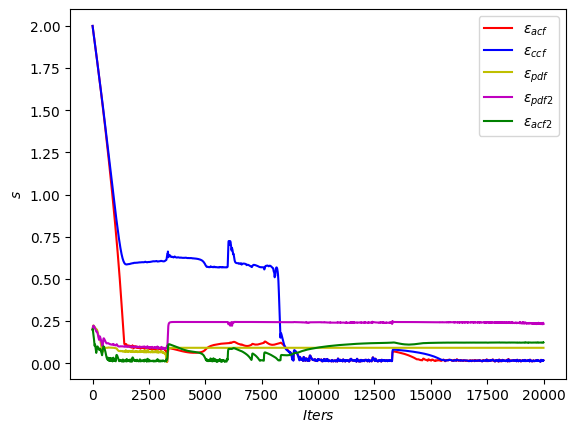

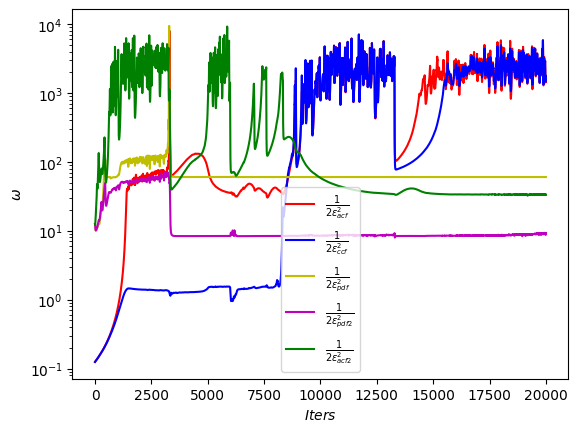

In [46]:
draw_adaptive_w(model1)
draw_epoch_w(model1)

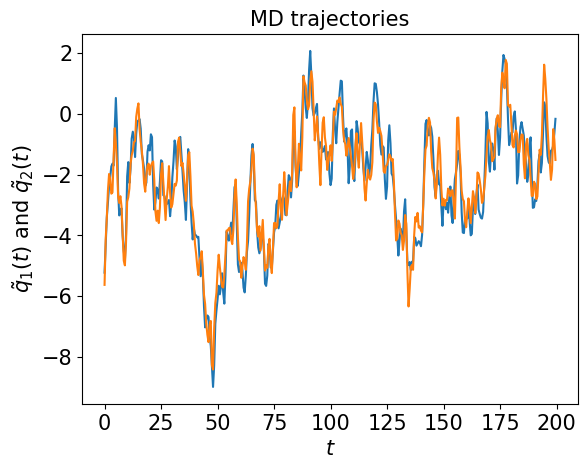

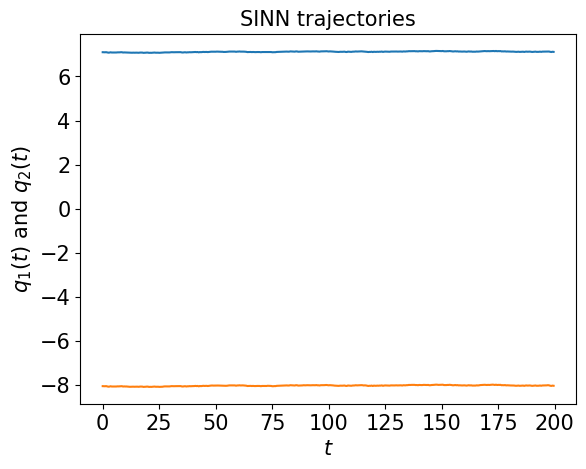

In [47]:
test1(model1)

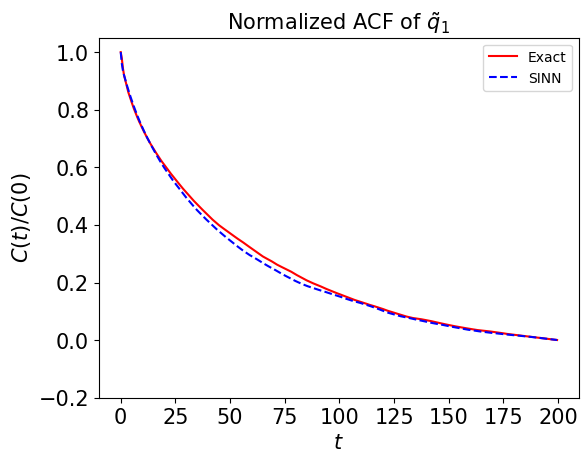

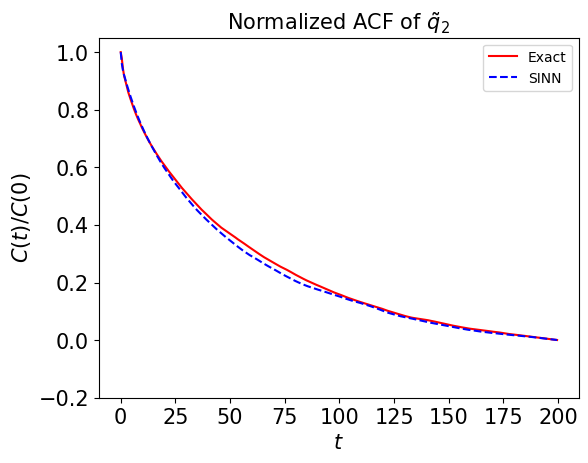

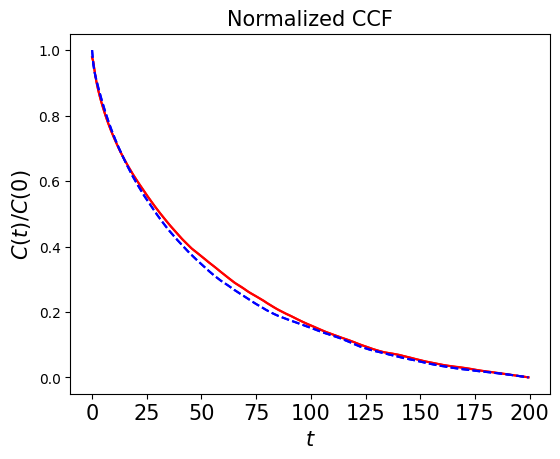

In [48]:
test2(model1)

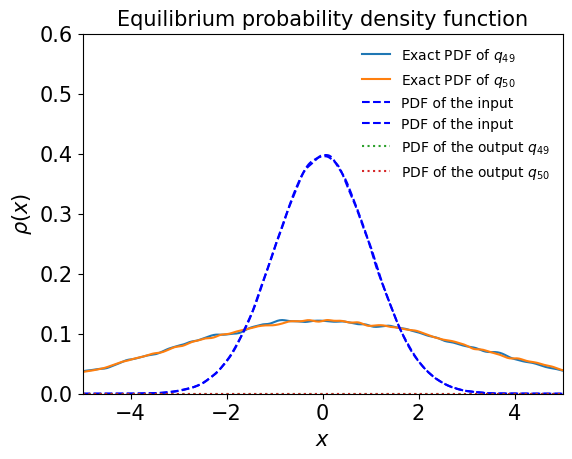

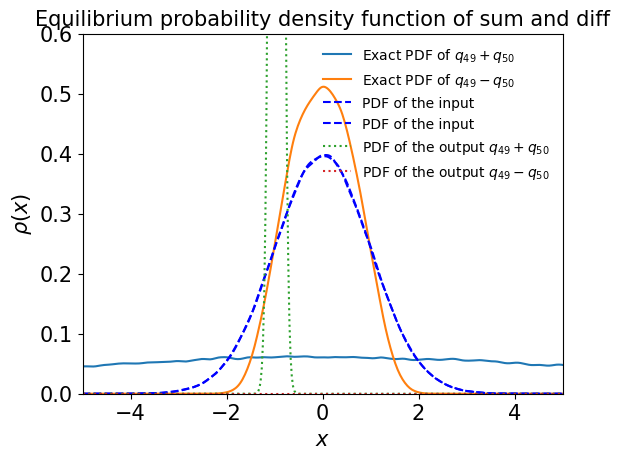

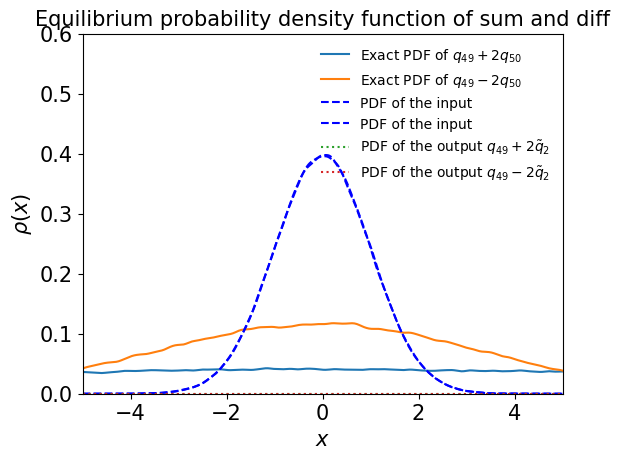

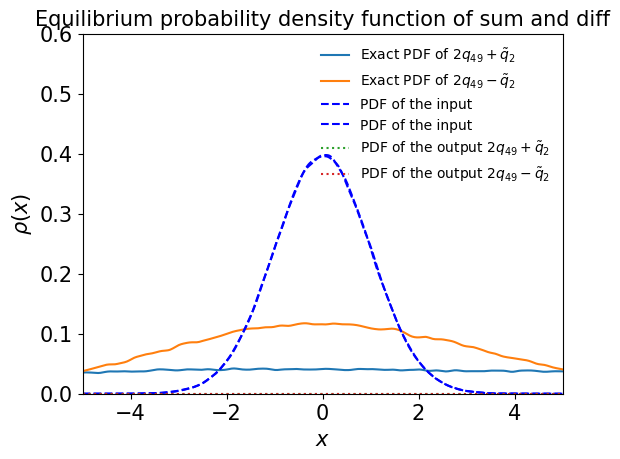

In [49]:
test3(model1)

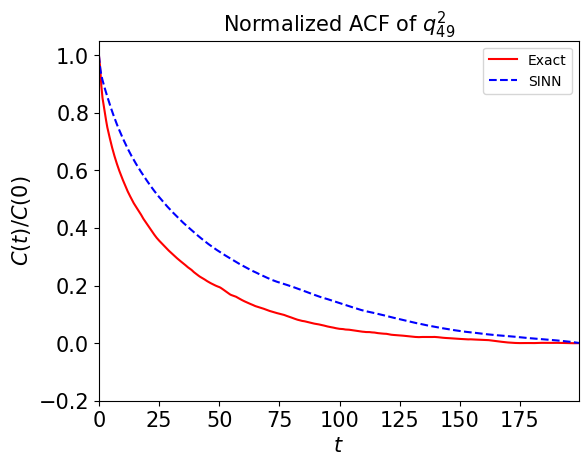

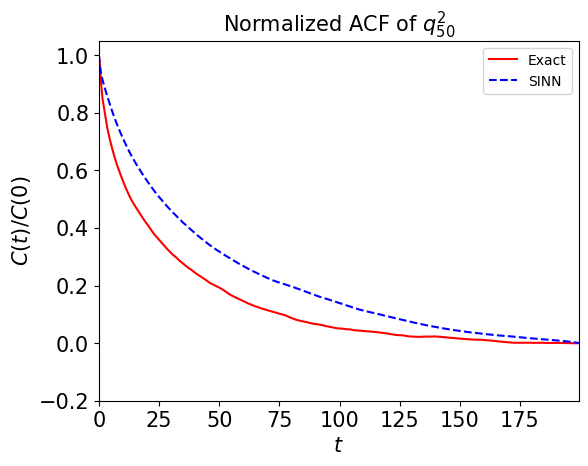

In [50]:
test4(model1)

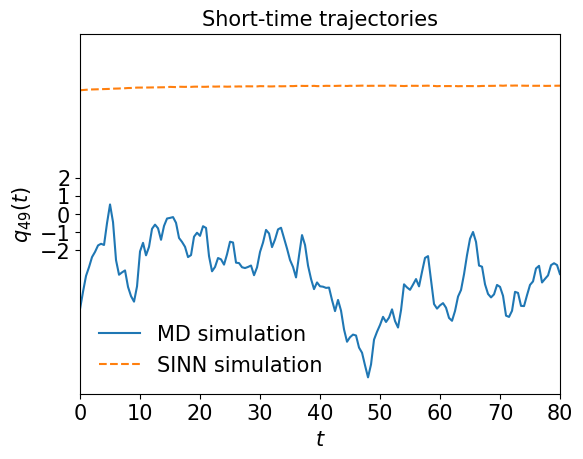

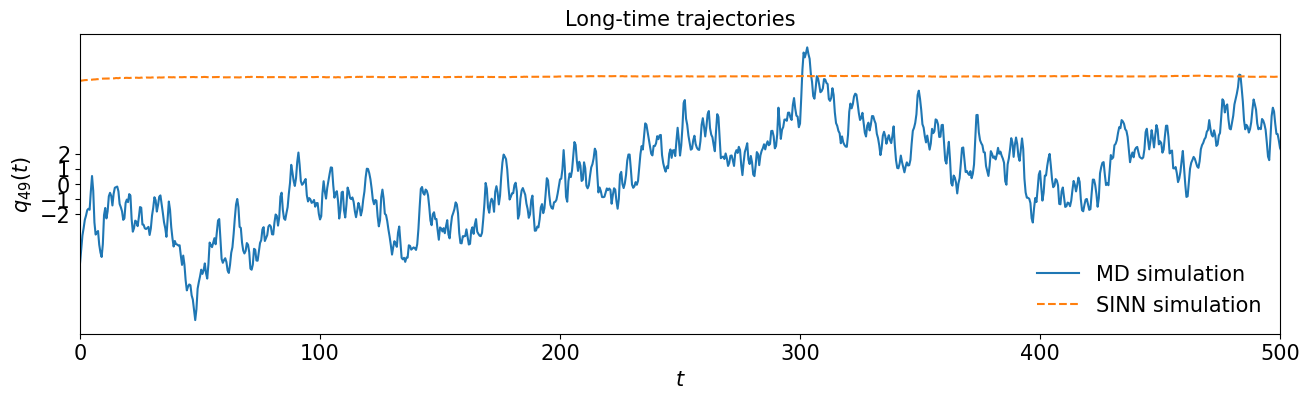

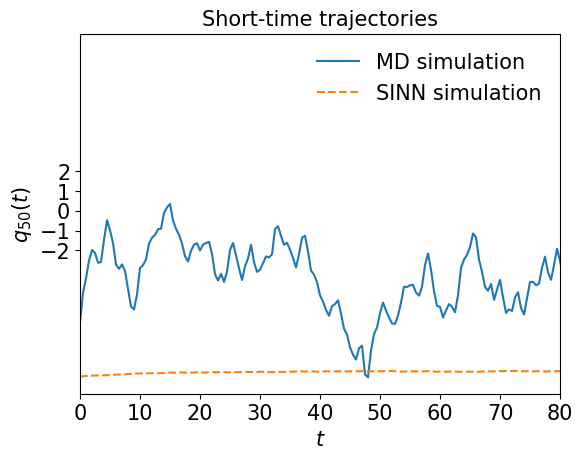

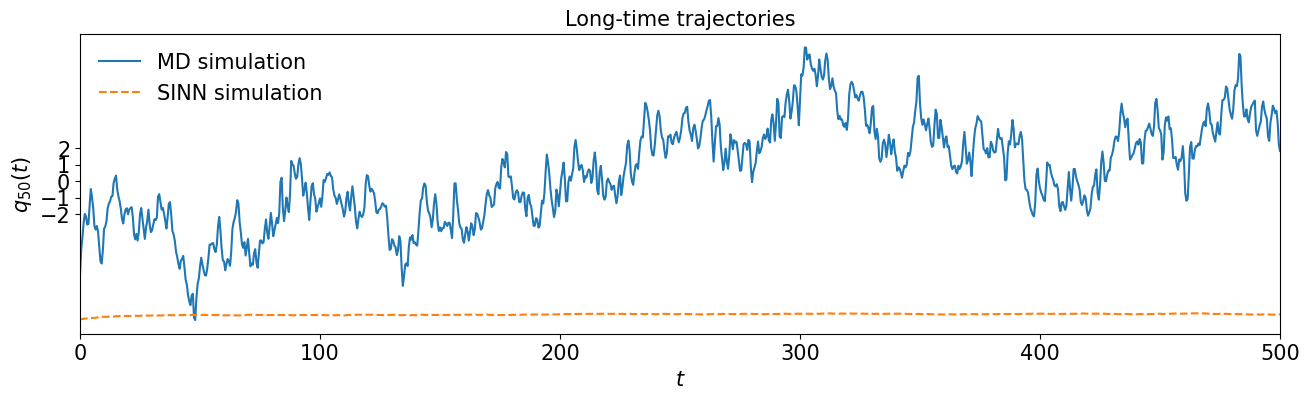

In [51]:
test5(model1)

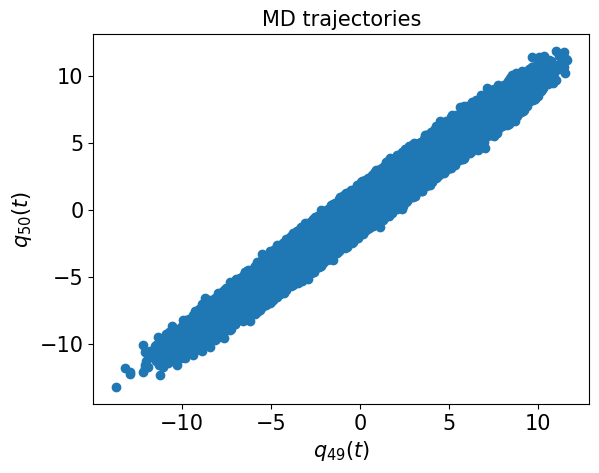

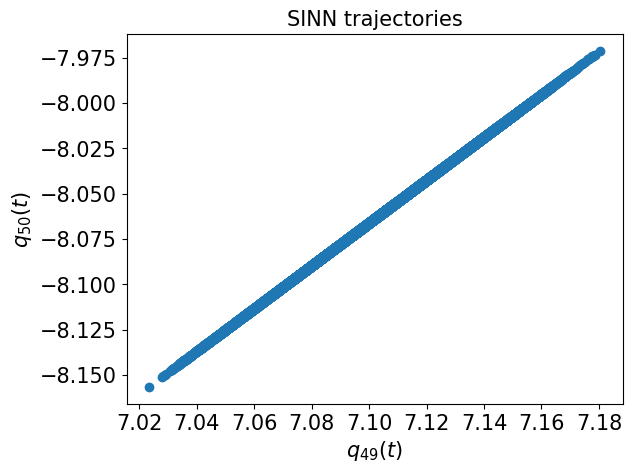

In [52]:
test6(model1)

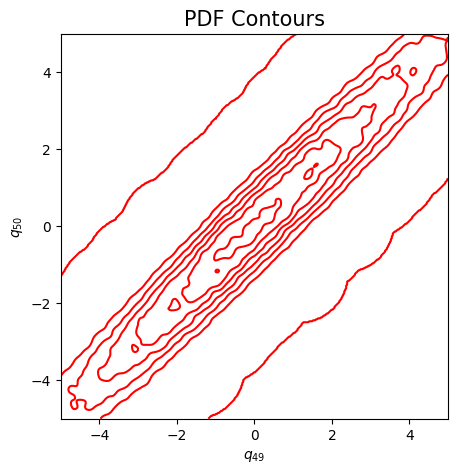

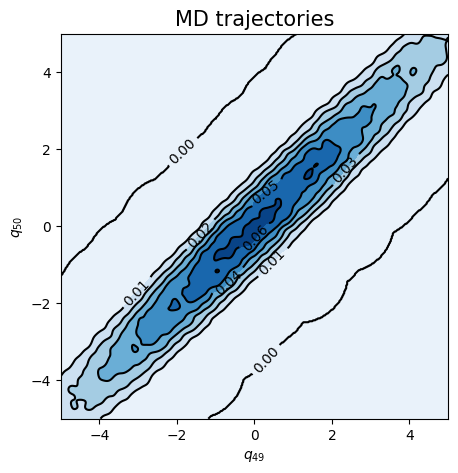

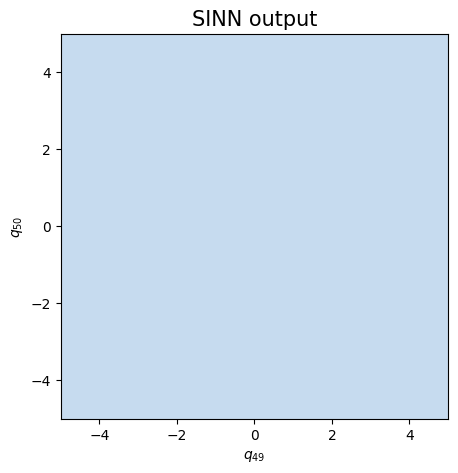

In [53]:
test7(model1)

In [54]:
### Defining SINN model
net2 = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.8360, 0.8195, acf: 0.09656, ccf: 0.09933, pdf: 0.29315, pdf2: 0.28990, acf2: 0.04058
[50]-th step loss: 0.0459, 0.0814, acf: 0.00345, ccf: 0.00333, pdf: 0.03649, pdf2: 0.02341, acf2: 0.01472
[100]-th step loss: 0.0818, 0.0416, acf: 0.01302, ccf: 0.01291, pdf: 0.00568, pdf2: 0.00655, acf2: 0.00341
[150]-th step loss: 0.0700, 0.0626, acf: 0.02533, ccf: 0.02533, pdf: 0.00537, pdf2: 0.00520, acf2: 0.00141
[200]-th step loss: 0.3866, 0.3469, acf: 0.02553, ccf: 0.26570, pdf: 0.00829, pdf2: 0.04506, acf2: 0.00229
[250]-th step loss: 0.3450, 0.3563, acf: 0.01746, ccf: 0.28565, pdf: 0.00829, pdf2: 0.04474, acf2: 0.00016
[300]-th step loss: 0.4005, 0.4084, acf: 0.01109, ccf: 0.34367, pdf: 0.00829, pdf2: 0.04471, acf2: 0.00059
[350]-th step loss: 0.3958, 0.4159, acf: 0.01005, ccf: 0.35191, pdf: 0.00829, pdf2: 0.04474, acf2: 0.00089
[400]-th step loss: 0.3944, 0.3963, acf: 0.01474, ccf: 0.32835, pdf: 0.00829, pdf2: 0.04470, acf2: 0.00019
[450]-th step loss: 0.3747, 0.3782, acf:

[3850]-th step loss: 0.3870, 0.3932, acf: 0.01439, ccf: 0.32594, pdf: 0.00829, pdf2: 0.04454, acf2: 0.00004
[3900]-th step loss: 0.3854, 0.3958, acf: 0.01391, ccf: 0.32901, pdf: 0.00829, pdf2: 0.04453, acf2: 0.00006
[3950]-th step loss: 0.3937, 0.3837, acf: 0.01621, ccf: 0.31451, pdf: 0.00829, pdf2: 0.04462, acf2: 0.00006
[4000]-th step loss: 0.3857, 0.3933, acf: 0.01460, ccf: 0.32591, pdf: 0.00829, pdf2: 0.04450, acf2: 0.00003
[4050]-th step loss: 0.3892, 0.3881, acf: 0.01558, ccf: 0.31972, pdf: 0.00829, pdf2: 0.04451, acf2: 0.00002
[4100]-th step loss: 0.3762, 0.3883, acf: 0.01490, ccf: 0.32052, pdf: 0.00829, pdf2: 0.04453, acf2: 0.00003
[4150]-th step loss: 0.3894, 0.3919, acf: 0.01476, ccf: 0.32428, pdf: 0.00829, pdf2: 0.04450, acf2: 0.00003
[4200]-th step loss: 0.3890, 0.3940, acf: 0.01410, ccf: 0.32702, pdf: 0.00829, pdf2: 0.04453, acf2: 0.00004
[4250]-th step loss: 0.4024, 0.3973, acf: 0.01227, ccf: 0.33200, pdf: 0.00829, pdf2: 0.04455, acf2: 0.00018
[4300]-th step loss: 0.3804,

[7650]-th step loss: 0.3876, 0.3866, acf: 0.01630, ccf: 0.31743, pdf: 0.00829, pdf2: 0.04452, acf2: 0.00007
[7700]-th step loss: 0.3912, 0.3823, acf: 0.01794, ccf: 0.31155, pdf: 0.00829, pdf2: 0.04437, acf2: 0.00017
[7750]-th step loss: 0.3926, 0.3879, acf: 0.01615, ccf: 0.31903, pdf: 0.00829, pdf2: 0.04432, acf2: 0.00007
[7800]-th step loss: 0.4031, 0.3918, acf: 0.01483, ccf: 0.32425, pdf: 0.00829, pdf2: 0.04436, acf2: 0.00006
[7850]-th step loss: 0.3879, 0.3895, acf: 0.01536, ccf: 0.32159, pdf: 0.00829, pdf2: 0.04422, acf2: 0.00005
[7900]-th step loss: 0.3838, 0.3875, acf: 0.01655, ccf: 0.31835, pdf: 0.00829, pdf2: 0.04425, acf2: 0.00010
[7950]-th step loss: 0.3796, 0.3780, acf: 0.01917, ccf: 0.30584, pdf: 0.00829, pdf2: 0.04441, acf2: 0.00031
[8000]-th step loss: 0.3783, 0.3825, acf: 0.01604, ccf: 0.31374, pdf: 0.00829, pdf2: 0.04427, acf2: 0.00017
[8050]-th step loss: 0.3900, 0.3870, acf: 0.01622, ccf: 0.31816, pdf: 0.00829, pdf2: 0.04427, acf2: 0.00007
[8100]-th step loss: 0.3893,

[11450]-th step loss: 0.3316, 0.3425, acf: 0.01307, ccf: 0.27805, pdf: 0.00829, pdf2: 0.04304, acf2: 0.00009
[11500]-th step loss: 0.3422, 0.3348, acf: 0.01635, ccf: 0.26760, pdf: 0.00829, pdf2: 0.04248, acf2: 0.00008
[11550]-th step loss: 0.3605, 0.3518, acf: 0.01395, ccf: 0.28752, pdf: 0.00829, pdf2: 0.04196, acf2: 0.00011
[11600]-th step loss: 0.3473, 0.3569, acf: 0.01252, ccf: 0.29379, pdf: 0.00829, pdf2: 0.04201, acf2: 0.00026
[11650]-th step loss: 0.3686, 0.3492, acf: 0.01685, ccf: 0.28411, pdf: 0.00829, pdf2: 0.03954, acf2: 0.00044
[11700]-th step loss: 0.3832, 0.3684, acf: 0.01344, ccf: 0.30347, pdf: 0.00829, pdf2: 0.04307, acf2: 0.00015
[11750]-th step loss: 0.3674, 0.3650, acf: 0.01486, ccf: 0.29908, pdf: 0.00829, pdf2: 0.04269, acf2: 0.00006
[11800]-th step loss: 0.3773, 0.3659, acf: 0.01385, ccf: 0.30110, pdf: 0.00829, pdf2: 0.04259, acf2: 0.00008
[11850]-th step loss: 0.3587, 0.3677, acf: 0.01340, ccf: 0.30360, pdf: 0.00829, pdf2: 0.04233, acf2: 0.00012
[11900]-th step los

[15250]-th step loss: 0.2432, 0.2211, acf: 0.01519, ccf: 0.19177, pdf: 0.00829, pdf2: 0.00579, acf2: 0.00007
[15300]-th step loss: 0.2154, 0.2253, acf: 0.01005, ccf: 0.20036, pdf: 0.00829, pdf2: 0.00564, acf2: 0.00093
[15350]-th step loss: 0.0687, 0.0663, acf: 0.01630, ccf: 0.03054, pdf: 0.00829, pdf2: 0.01068, acf2: 0.00048
[15400]-th step loss: 0.0451, 0.0571, acf: 0.02030, ccf: 0.02080, pdf: 0.00829, pdf2: 0.00721, acf2: 0.00053
[15450]-th step loss: 0.0854, 0.0939, acf: 0.03610, ccf: 0.03644, pdf: 0.00829, pdf2: 0.00769, acf2: 0.00537
[15500]-th step loss: 0.0333, 0.0331, acf: 0.00250, ccf: 0.00251, pdf: 0.00829, pdf2: 0.01353, acf2: 0.00629
[15550]-th step loss: 0.0291, 0.0300, acf: 0.00706, ccf: 0.00738, pdf: 0.00829, pdf2: 0.00547, acf2: 0.00180
[15600]-th step loss: 0.0275, 0.0262, acf: 0.00373, ccf: 0.00386, pdf: 0.00829, pdf2: 0.00623, acf2: 0.00404
[15650]-th step loss: 0.0272, 0.0405, acf: 0.00108, ccf: 0.00094, pdf: 0.00829, pdf2: 0.00714, acf2: 0.02301
[15700]-th step los

[19050]-th step loss: 0.0271, 0.0272, acf: 0.00002, ccf: 0.00002, pdf: 0.00829, pdf2: 0.00428, acf2: 0.01456
[19100]-th step loss: 0.0278, 0.0259, acf: 0.00004, ccf: 0.00004, pdf: 0.00829, pdf2: 0.00435, acf2: 0.01321
[19150]-th step loss: 0.0269, 0.0267, acf: 0.00001, ccf: 0.00002, pdf: 0.00829, pdf2: 0.00426, acf2: 0.01409
[19200]-th step loss: 0.0255, 0.0291, acf: 0.00008, ccf: 0.00009, pdf: 0.00829, pdf2: 0.00438, acf2: 0.01626
[19250]-th step loss: 0.0264, 0.0265, acf: 0.00005, ccf: 0.00005, pdf: 0.00829, pdf2: 0.00447, acf2: 0.01365
[19300]-th step loss: 0.0245, 0.0264, acf: 0.00002, ccf: 0.00003, pdf: 0.00829, pdf2: 0.00422, acf2: 0.01382
[19350]-th step loss: 0.0270, 0.0258, acf: 0.00012, ccf: 0.00012, pdf: 0.00829, pdf2: 0.00443, acf2: 0.01280
[19400]-th step loss: 0.0297, 0.0295, acf: 0.00009, ccf: 0.00009, pdf: 0.00829, pdf2: 0.00451, acf2: 0.01652
[19450]-th step loss: 0.0248, 0.0267, acf: 0.00002, ccf: 0.00002, pdf: 0.00829, pdf2: 0.00413, acf2: 0.01420
[19500]-th step los

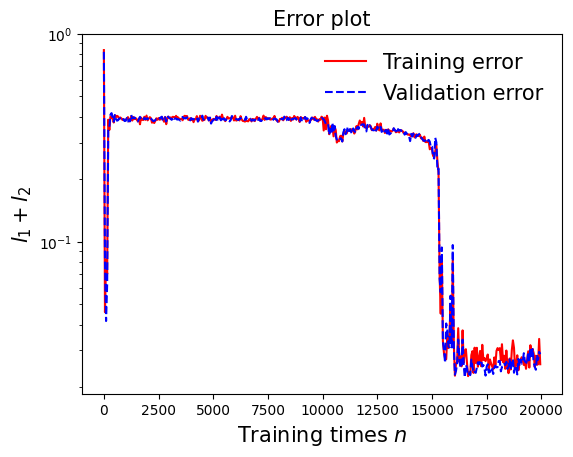

In [55]:
draw_loss(model2)

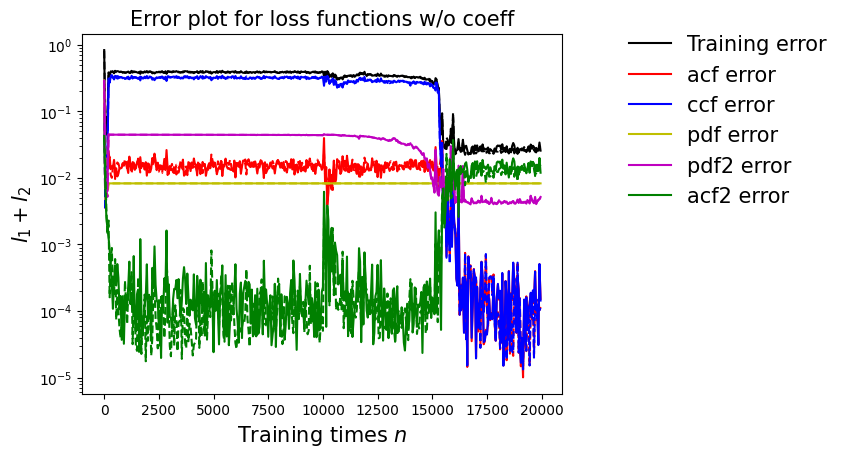

In [56]:
draw_errors(model2)

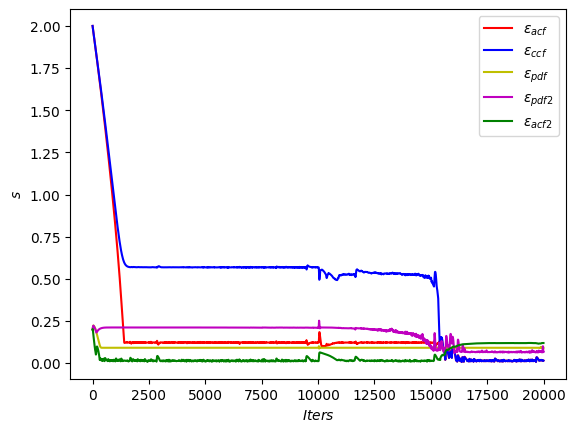

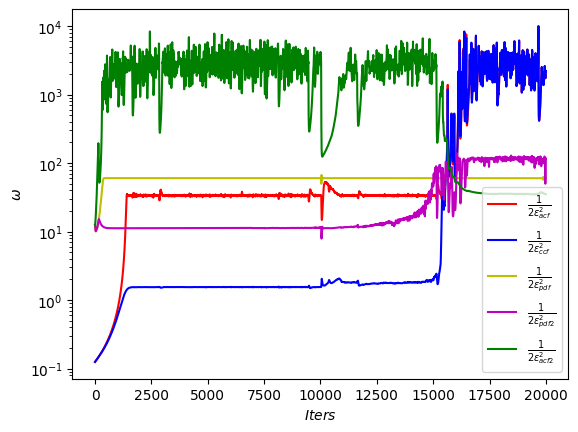

In [57]:
draw_adaptive_w(model2)
draw_epoch_w(model2)

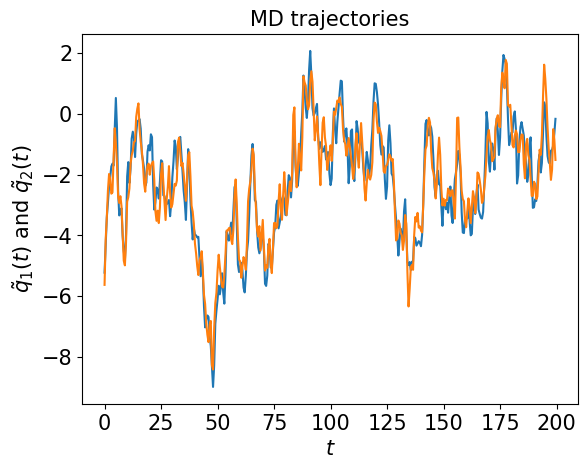

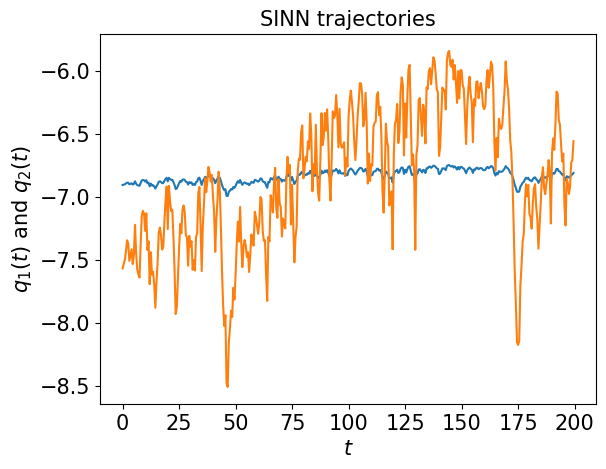

In [58]:
test1(model2)

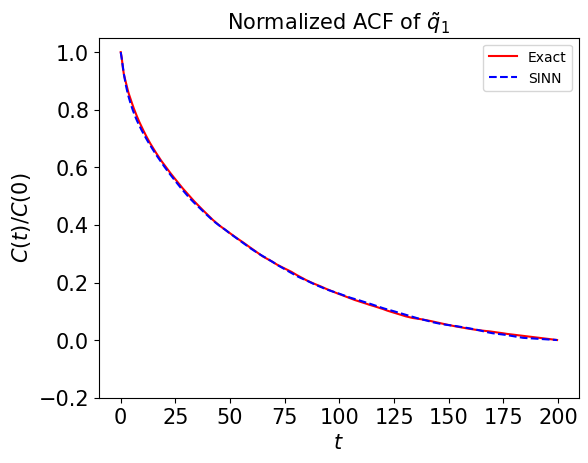

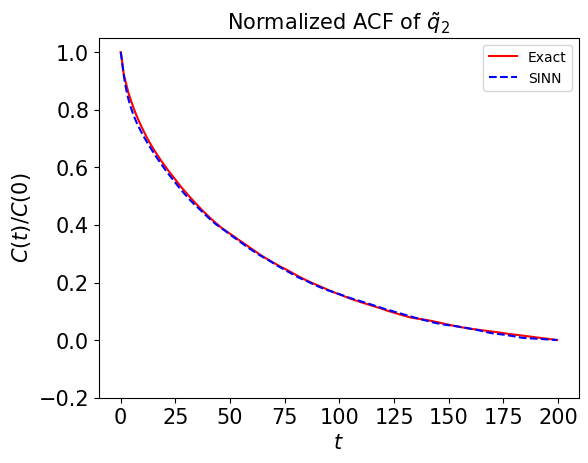

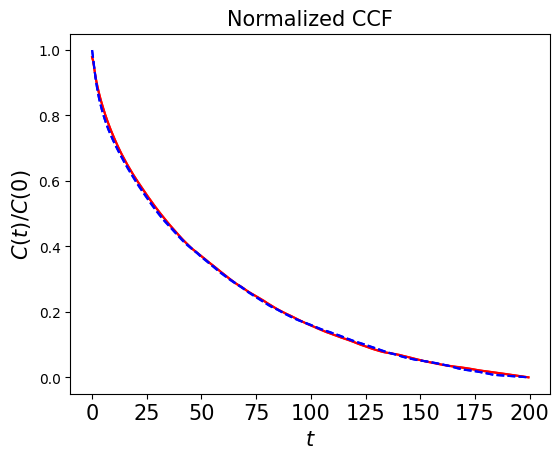

In [59]:
test2(model2)

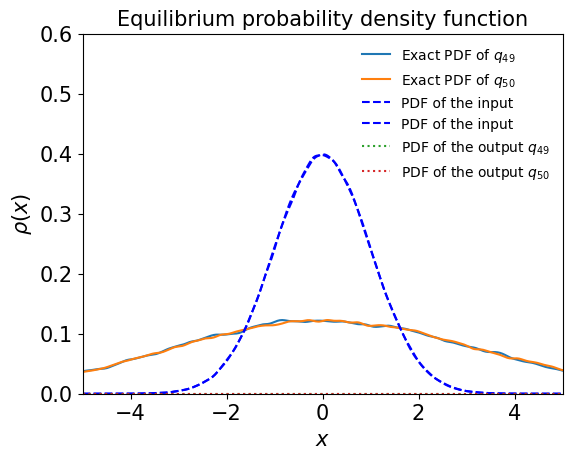

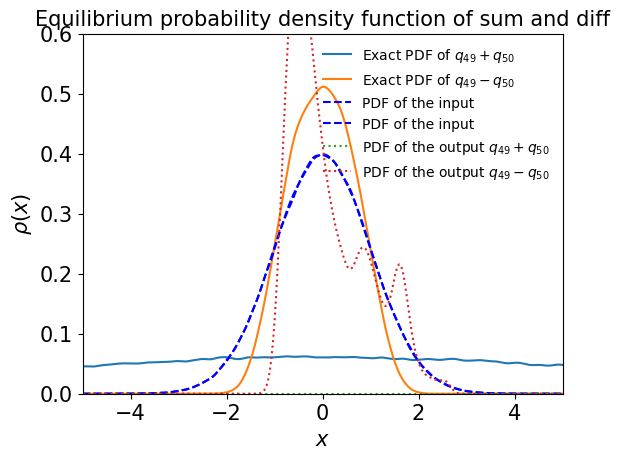

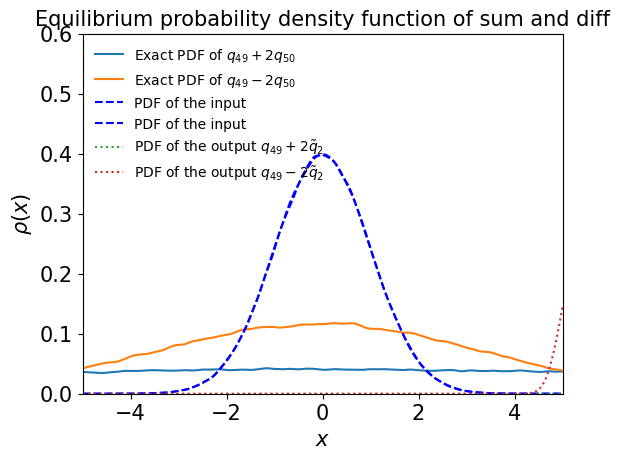

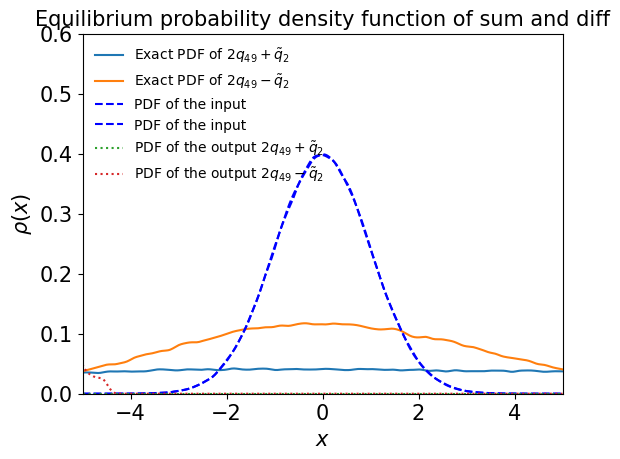

In [60]:
test3(model2)

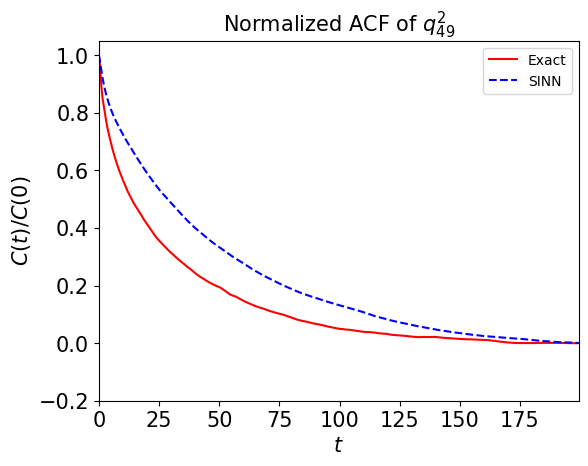

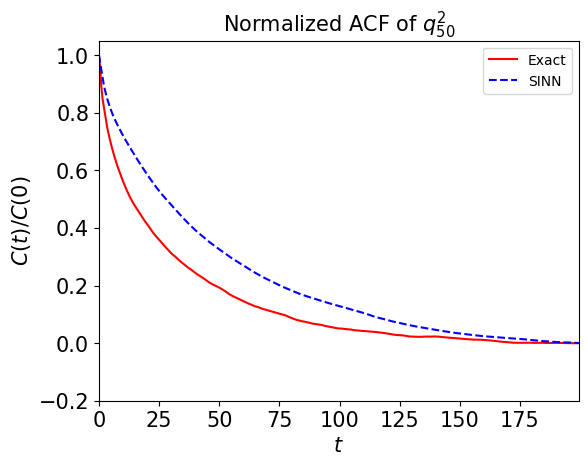

In [61]:
test4(model2)

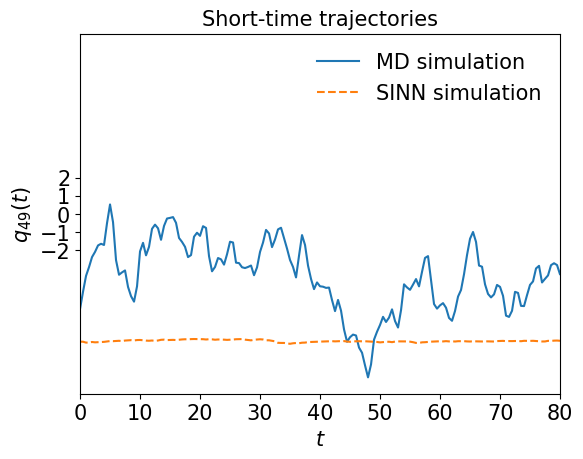

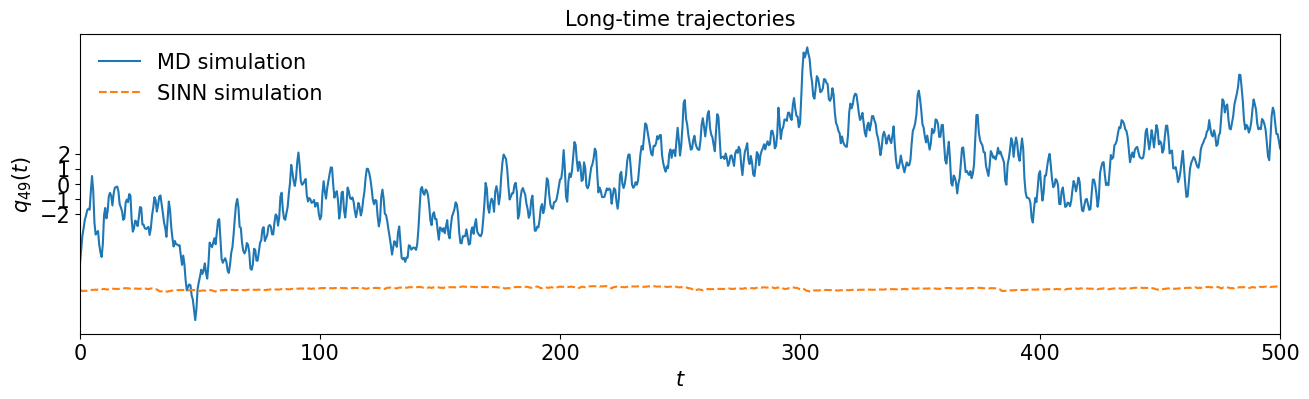

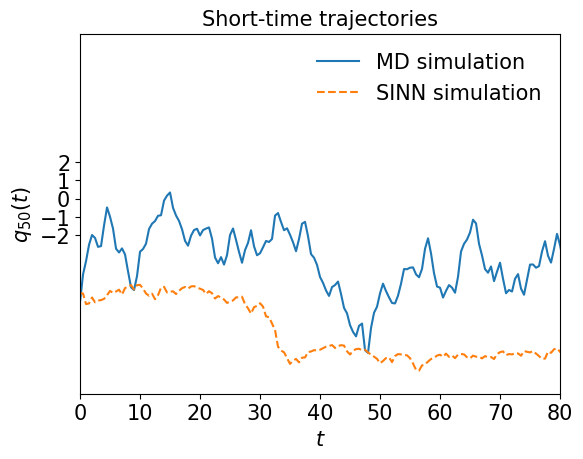

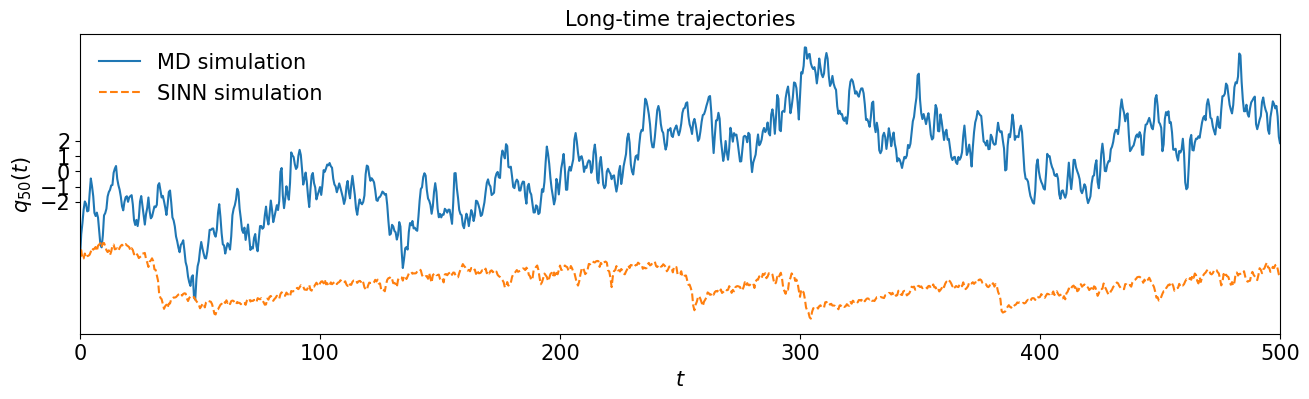

In [62]:
test5(model2)

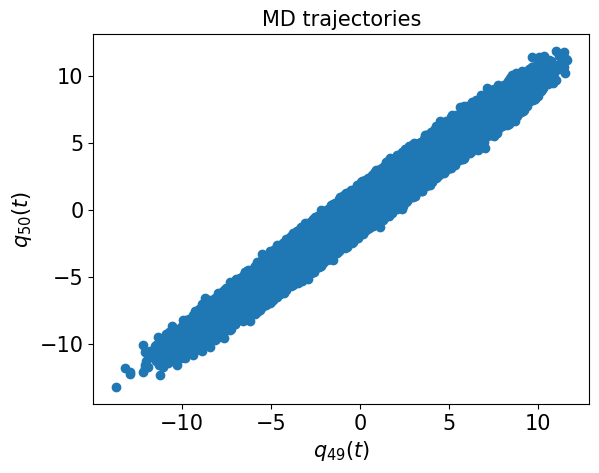

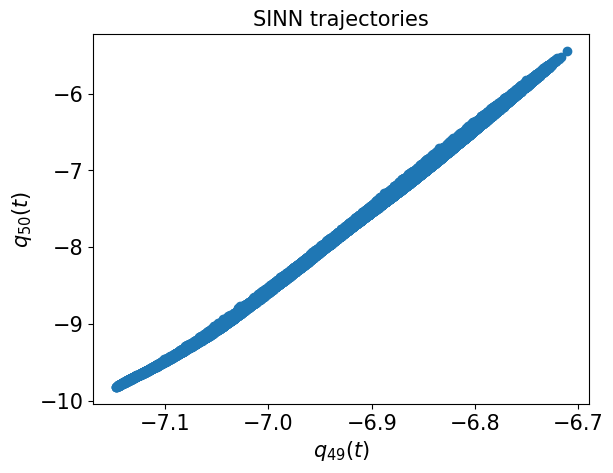

In [63]:
test6(model2)

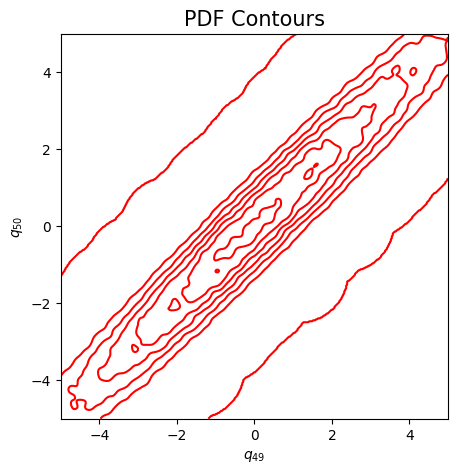

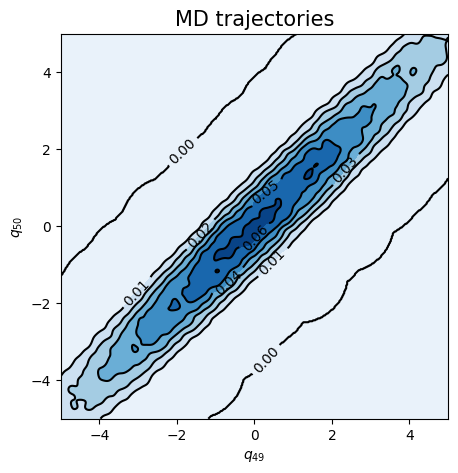

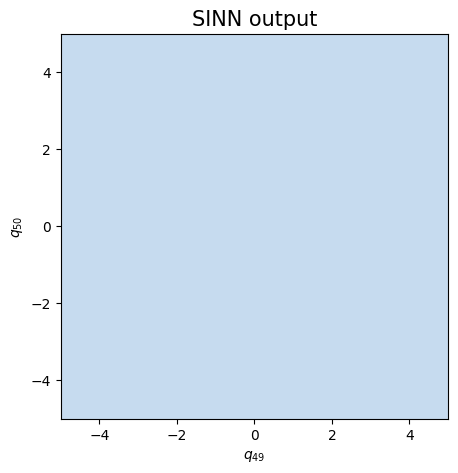

In [64]:
test7(model2)

In [65]:
### Defining SINN model
net3 = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.8293, 0.8244, acf: 0.09885, ccf: 0.10043, pdf: 0.29318, pdf2: 0.28968, acf2: 0.04230
[50]-th step loss: 0.0750, 0.0554, acf: 0.01459, ccf: 0.01456, pdf: 0.01347, pdf2: 0.00985, acf2: 0.00297
[100]-th step loss: 0.0625, 0.0526, acf: 0.01581, ccf: 0.01581, pdf: 0.00980, pdf2: 0.00782, acf2: 0.00337
[150]-th step loss: 0.0822, 0.2143, acf: 0.06262, ccf: 0.08604, pdf: 0.00829, pdf2: 0.04000, acf2: 0.01737
[200]-th step loss: 0.0246, 0.0430, acf: 0.01471, ccf: 0.01481, pdf: 0.00589, pdf2: 0.00503, acf2: 0.00261
[250]-th step loss: 0.0410, 0.0459, acf: 0.01963, ccf: 0.01965, pdf: 0.00174, pdf2: 0.00184, acf2: 0.00300
[300]-th step loss: 0.0244, 0.0194, acf: 0.00671, ccf: 0.00682, pdf: 0.00067, pdf2: 0.00081, acf2: 0.00439
[350]-th step loss: 0.0895, 0.0837, acf: 0.01330, ccf: 0.01332, pdf: 0.00829, pdf2: 0.04498, acf2: 0.00376
[400]-th step loss: 0.0806, 0.0856, acf: 0.01622, ccf: 0.01620, pdf: 0.00829, pdf2: 0.04475, acf2: 0.00015
[450]-th step loss: 0.0864, 0.0913, acf:

[3850]-th step loss: 0.0008, 0.0013, acf: 0.00030, ccf: 0.00019, pdf: 0.00036, pdf2: 0.00019, acf2: 0.00023
[3900]-th step loss: 0.0014, 0.0008, acf: 0.00017, ccf: 0.00009, pdf: 0.00008, pdf2: 0.00006, acf2: 0.00041
[3950]-th step loss: 0.0007, 0.0004, acf: 0.00018, ccf: 0.00003, pdf: 0.00004, pdf2: 0.00004, acf2: 0.00009
[4000]-th step loss: 0.0009, 0.0008, acf: 0.00015, ccf: 0.00005, pdf: 0.00009, pdf2: 0.00025, acf2: 0.00024
[4050]-th step loss: 0.0009, 0.0013, acf: 0.00019, ccf: 0.00013, pdf: 0.00031, pdf2: 0.00030, acf2: 0.00034
[4100]-th step loss: 0.0017, 0.0008, acf: 0.00026, ccf: 0.00012, pdf: 0.00009, pdf2: 0.00013, acf2: 0.00016
[4150]-th step loss: 0.0005, 0.0008, acf: 0.00026, ccf: 0.00013, pdf: 0.00016, pdf2: 0.00014, acf2: 0.00013
[4200]-th step loss: 0.0009, 0.0006, acf: 0.00007, ccf: 0.00005, pdf: 0.00012, pdf2: 0.00010, acf2: 0.00028
[4250]-th step loss: 0.0005, 0.0007, acf: 0.00023, ccf: 0.00011, pdf: 0.00006, pdf2: 0.00003, acf2: 0.00031
[4300]-th step loss: 0.0006,

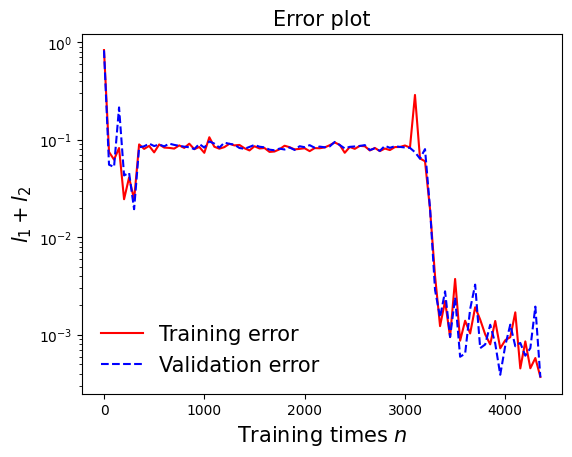

In [66]:
draw_loss(model3)

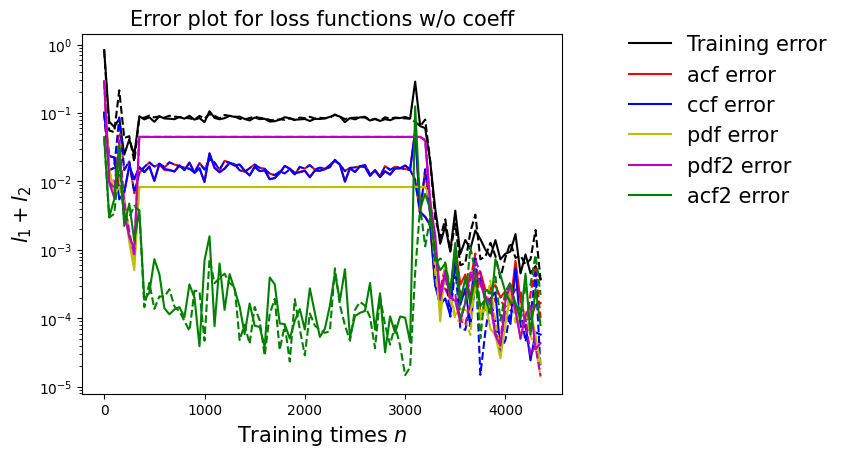

In [67]:
draw_errors(model3)

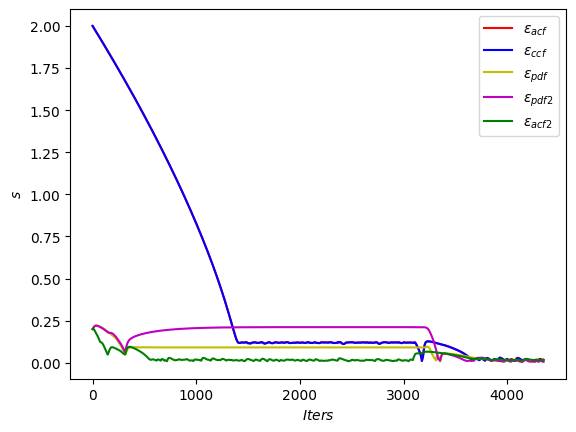

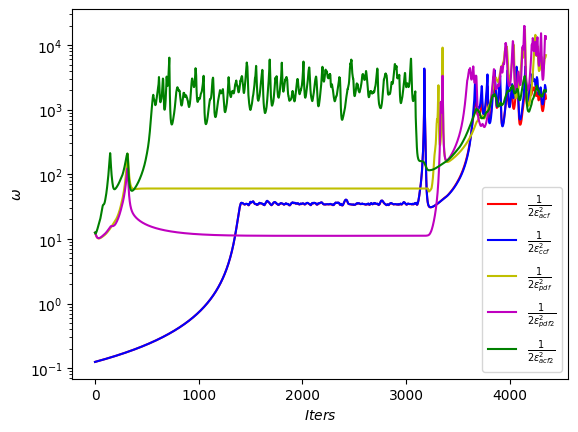

In [68]:
draw_adaptive_w(model3)
draw_epoch_w(model3)

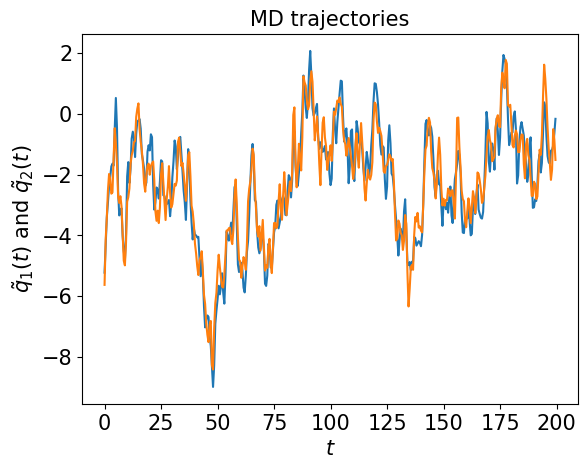

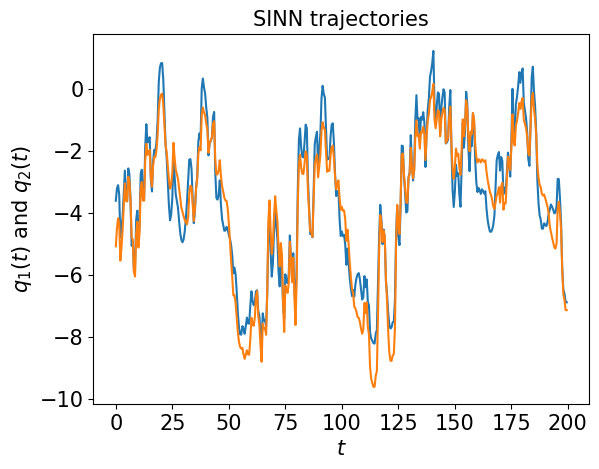

In [69]:
test1(model3)

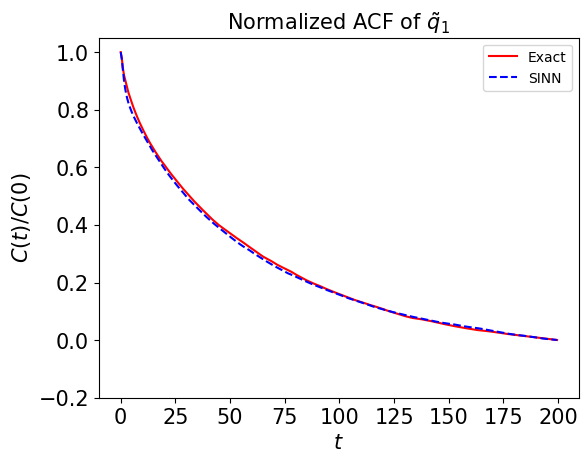

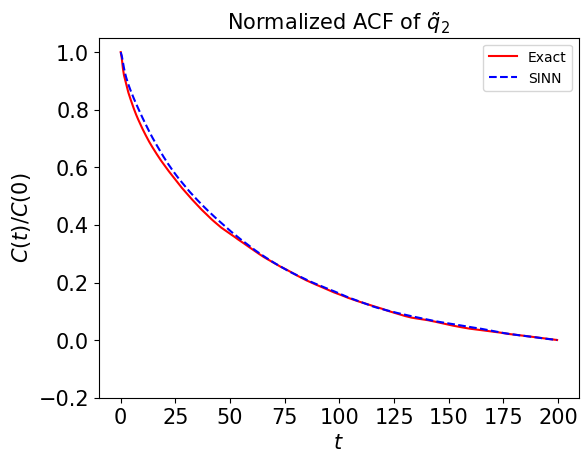

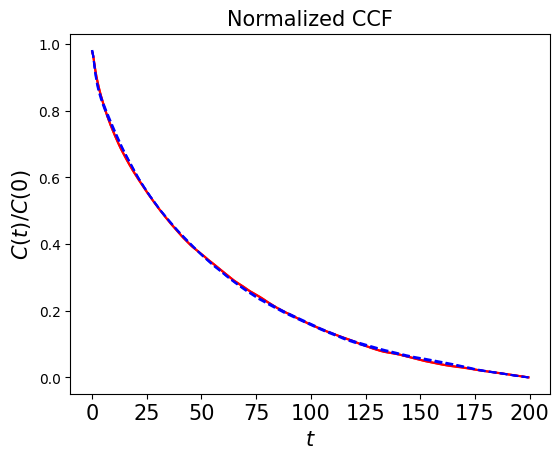

In [70]:
test2(model3)

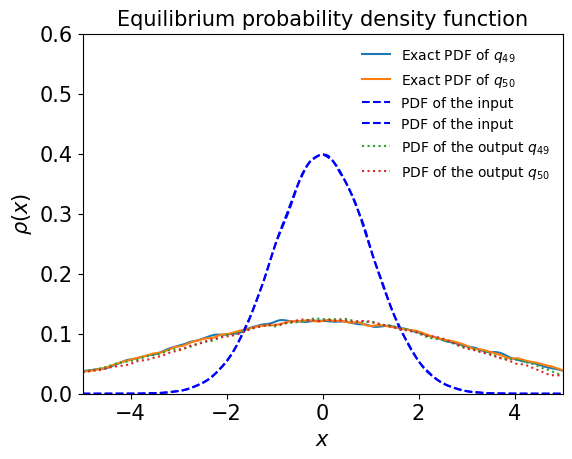

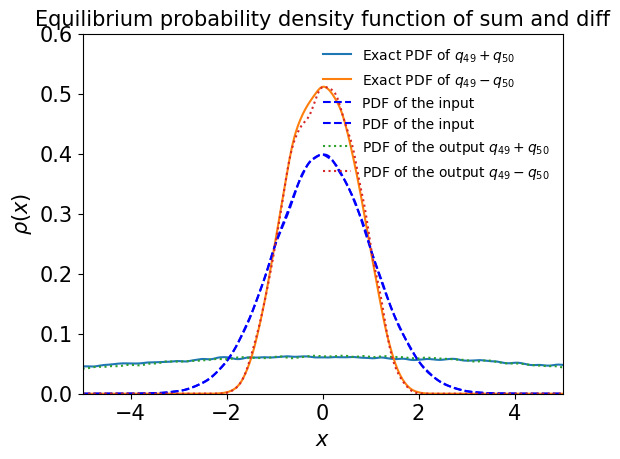

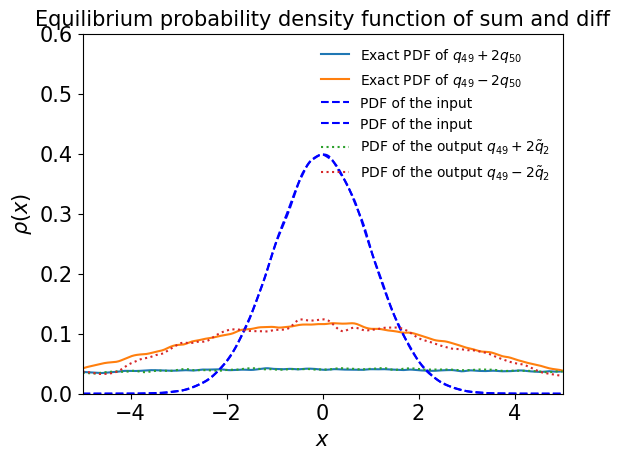

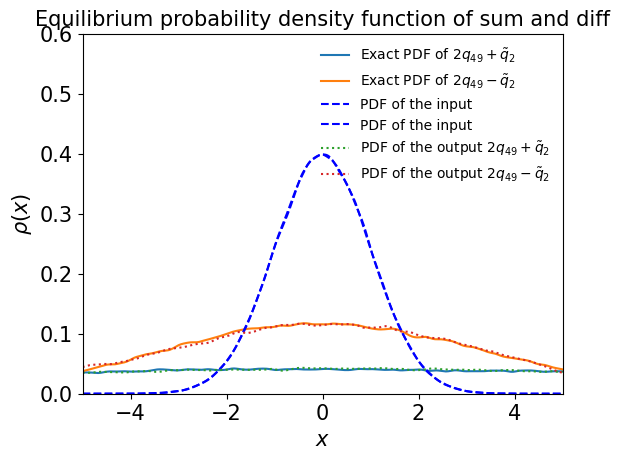

In [71]:
test3(model3)

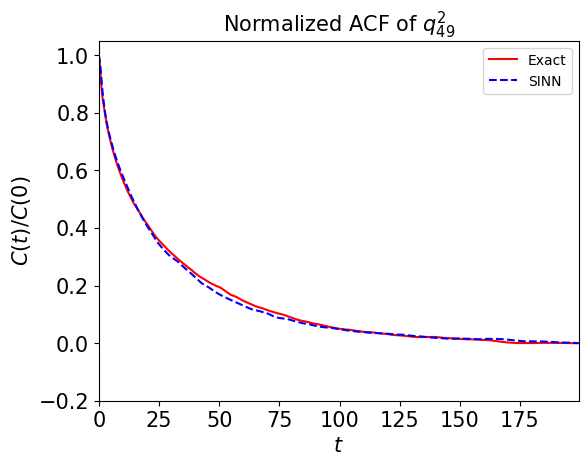

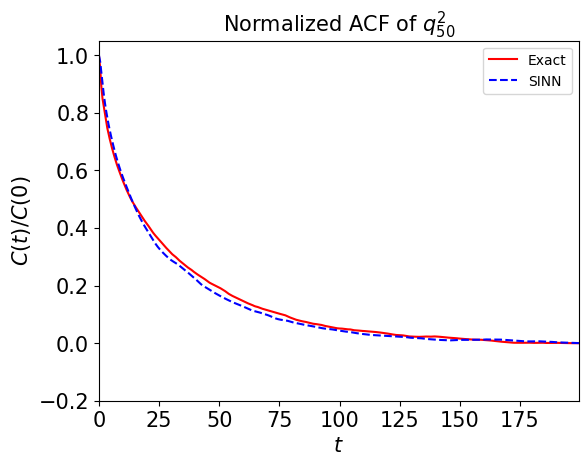

In [72]:
test4(model3)

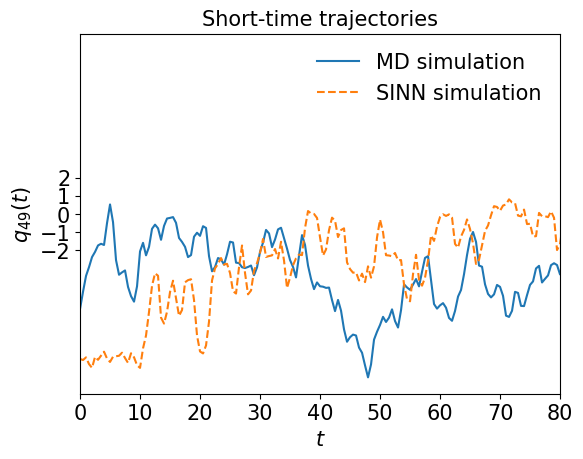

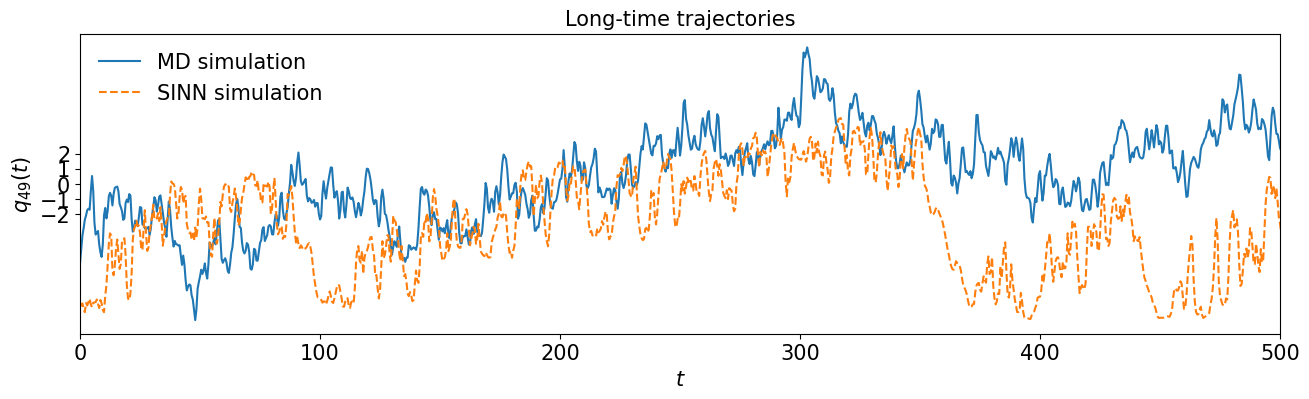

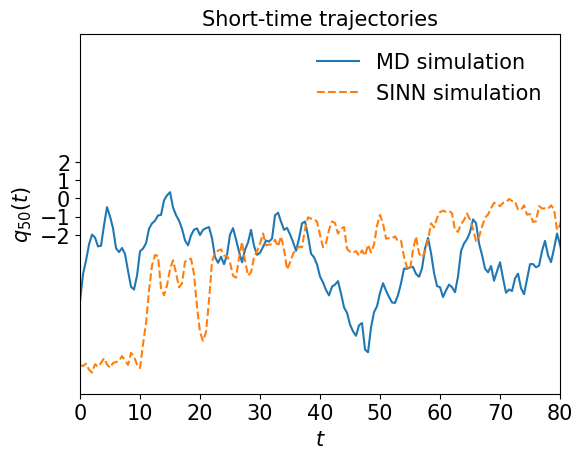

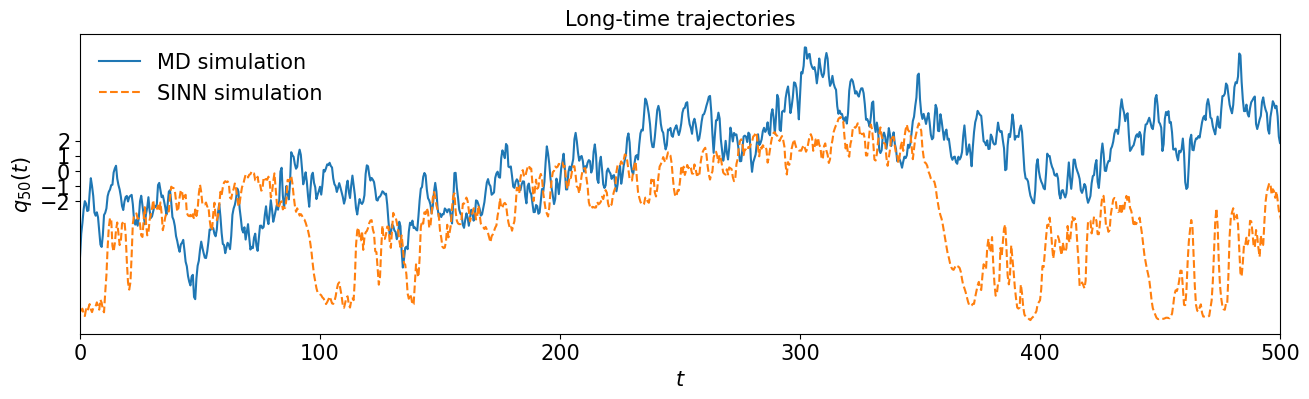

In [73]:
test5(model3)

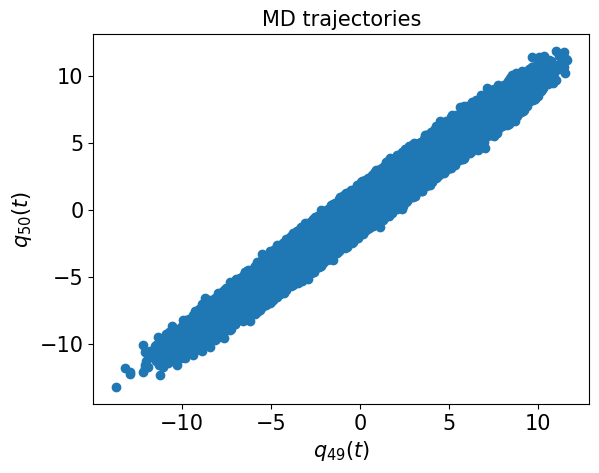

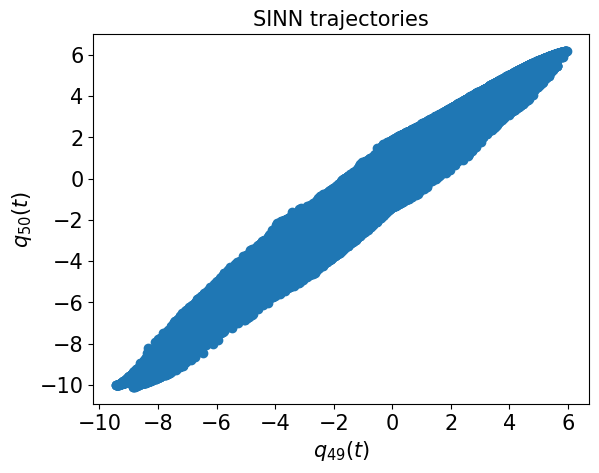

In [74]:
test6(model3)

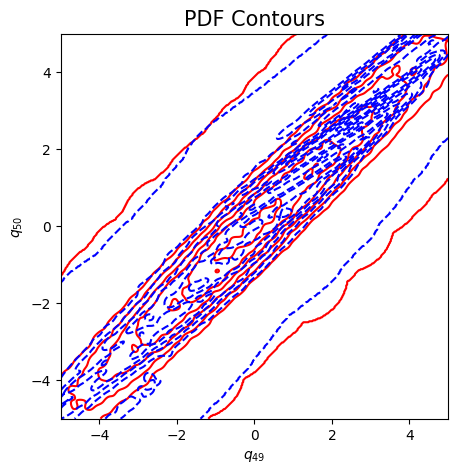

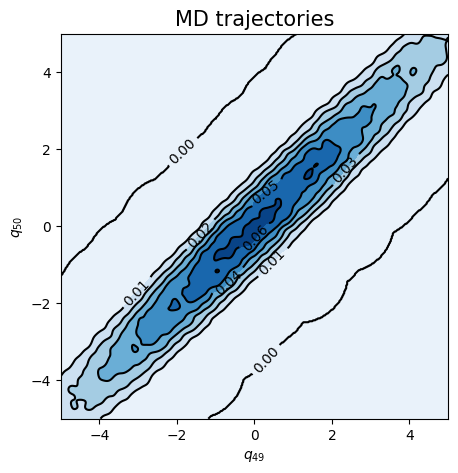

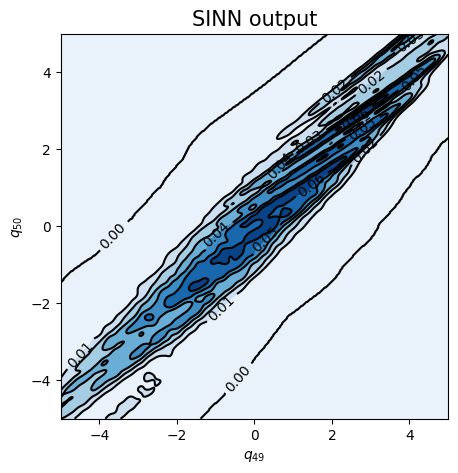

In [75]:
test7(model3)

In [76]:
### Defining SINN model
net4 = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.8605, 0.8420, acf: 0.09663, ccf: 0.12192, pdf: 0.29313, pdf2: 0.28976, acf2: 0.04054
[50]-th step loss: 0.2516, 0.2259, acf: 0.03554, ccf: 0.16899, pdf: 0.00849, pdf2: 0.00775, acf2: 0.00512
[100]-th step loss: 0.2923, 0.3291, acf: 0.01965, ccf: 0.28861, pdf: 0.01088, pdf2: 0.00803, acf2: 0.00193
[150]-th step loss: 0.1784, 0.1570, acf: 0.05254, ccf: 0.08042, pdf: 0.01043, pdf2: 0.00984, acf2: 0.00381
[200]-th step loss: 0.3328, 0.3529, acf: 0.01381, ccf: 0.32157, pdf: 0.00850, pdf2: 0.00800, acf2: 0.00104
[250]-th step loss: 0.2867, 0.3242, acf: 0.01544, ccf: 0.29553, pdf: 0.00599, pdf2: 0.00664, acf2: 0.00064
[300]-th step loss: 0.3154, 0.3082, acf: 0.02425, ccf: 0.27072, pdf: 0.00478, pdf2: 0.00717, acf2: 0.00126
[350]-th step loss: 0.3240, 0.3307, acf: 0.01770, ccf: 0.30199, pdf: 0.00353, pdf2: 0.00718, acf2: 0.00032
[400]-th step loss: 0.3411, 0.3528, acf: 0.01248, ccf: 0.32979, pdf: 0.00253, pdf2: 0.00752, acf2: 0.00050
[450]-th step loss: 0.3503, 0.3503, acf:

[3850]-th step loss: 0.2468, 0.2412, acf: 0.00017, ccf: 0.23649, pdf: 0.00001, pdf2: 0.00435, acf2: 0.00019
[3900]-th step loss: 0.4527, 0.4473, acf: 0.00156, ccf: 0.43571, pdf: 0.00057, pdf2: 0.00648, acf2: 0.00298
[3950]-th step loss: 0.3743, 0.3740, acf: 0.00029, ccf: 0.36744, pdf: 0.00029, pdf2: 0.00577, acf2: 0.00026
[4000]-th step loss: 0.3202, 0.3226, acf: 0.00017, ccf: 0.31694, pdf: 0.00027, pdf2: 0.00504, acf2: 0.00020
[4050]-th step loss: 0.2646, 0.2667, acf: 0.00006, ccf: 0.26162, pdf: 0.00019, pdf2: 0.00471, acf2: 0.00015
[4100]-th step loss: 0.2267, 0.2275, acf: 0.00010, ccf: 0.22255, pdf: 0.00019, pdf2: 0.00440, acf2: 0.00022
[4150]-th step loss: 0.2103, 0.1990, acf: 0.00025, ccf: 0.19461, pdf: 0.00017, pdf2: 0.00385, acf2: 0.00008
[4200]-th step loss: 0.0289, 0.0163, acf: 0.00032, ccf: 0.01158, pdf: 0.00049, pdf2: 0.00340, acf2: 0.00051
[4250]-th step loss: 0.0117, 0.0137, acf: 0.00053, ccf: 0.00900, pdf: 0.00030, pdf2: 0.00307, acf2: 0.00084
[4300]-th step loss: 0.0040,

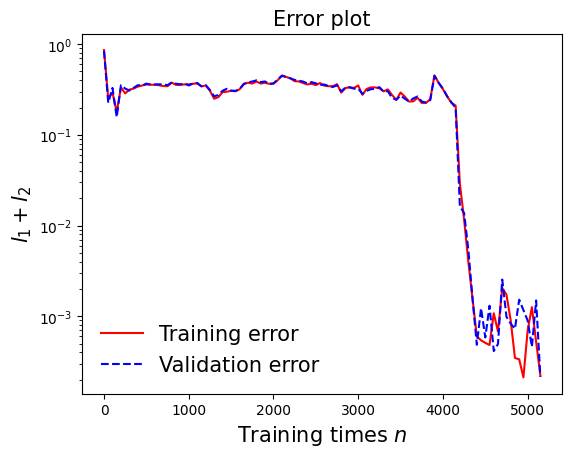

In [77]:
draw_loss(model4)

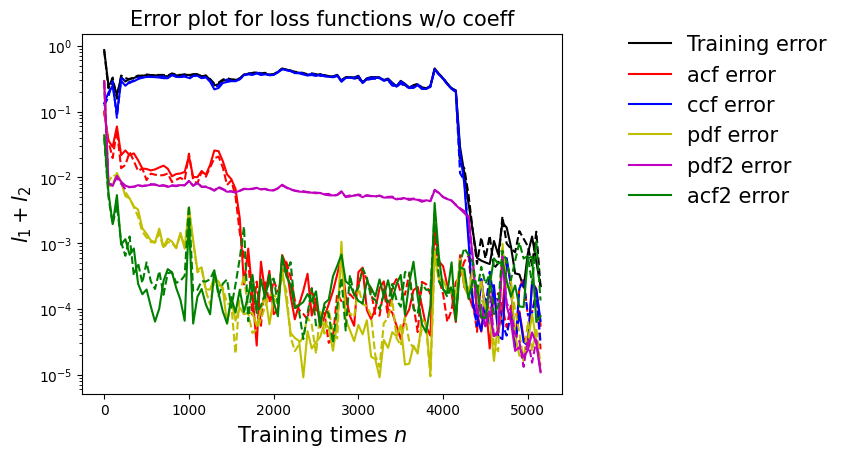

In [78]:
draw_errors(model4)

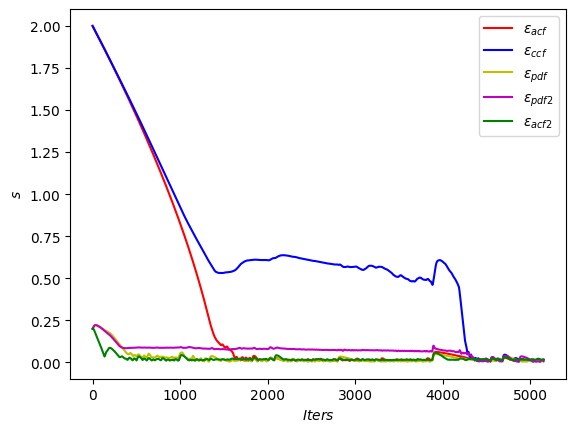

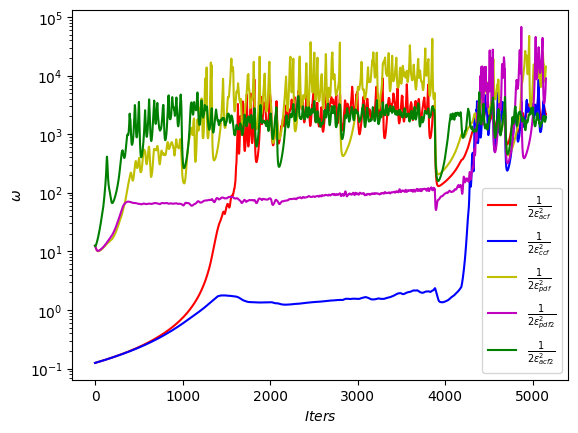

In [79]:
draw_adaptive_w(model4)
draw_epoch_w(model4)

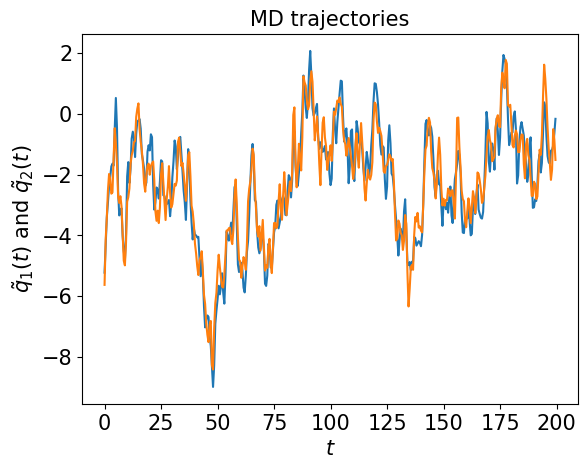

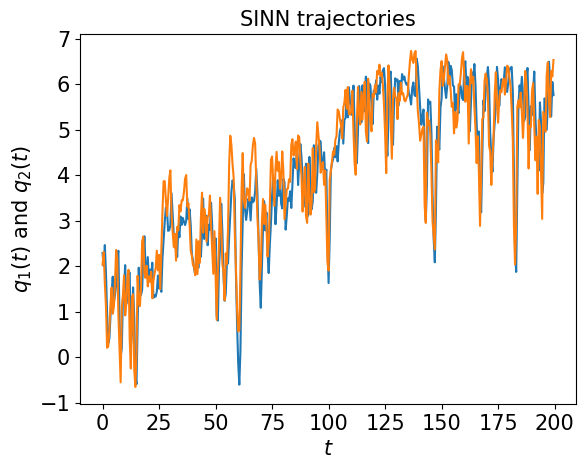

In [80]:
test1(model4)

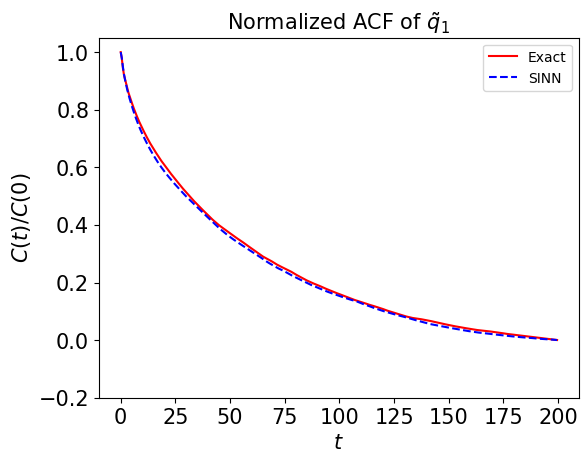

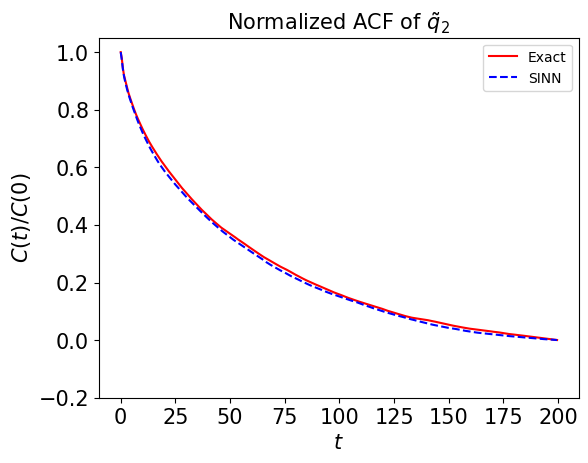

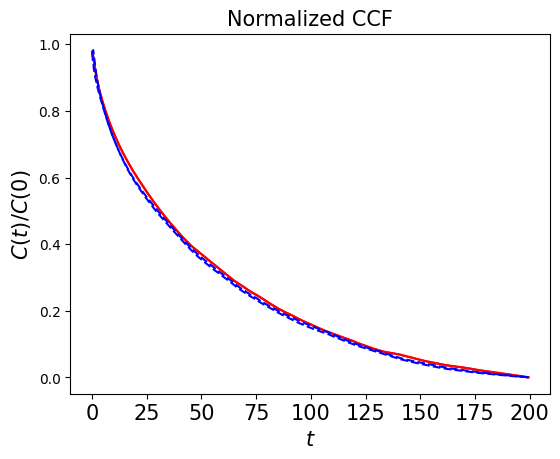

In [81]:
test2(model4)

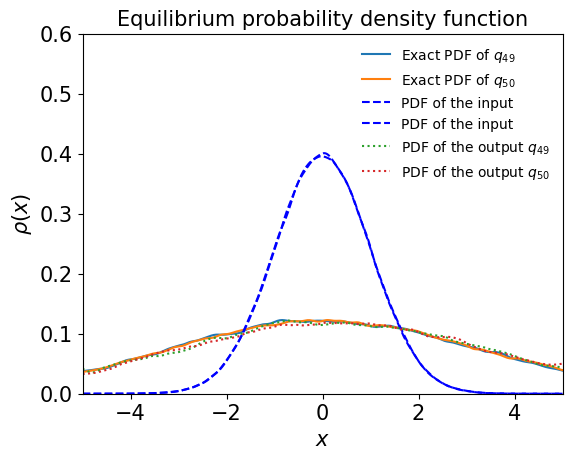

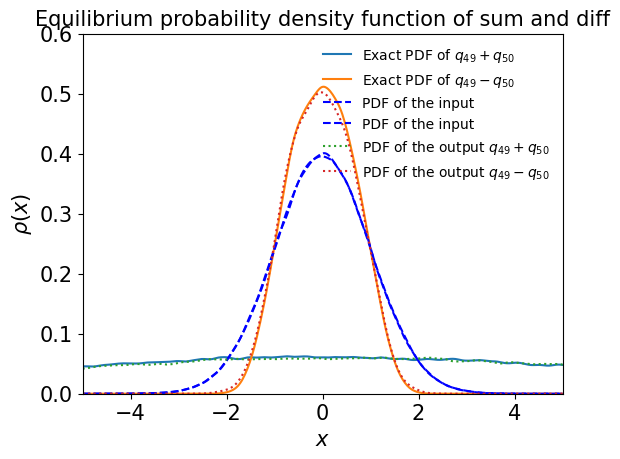

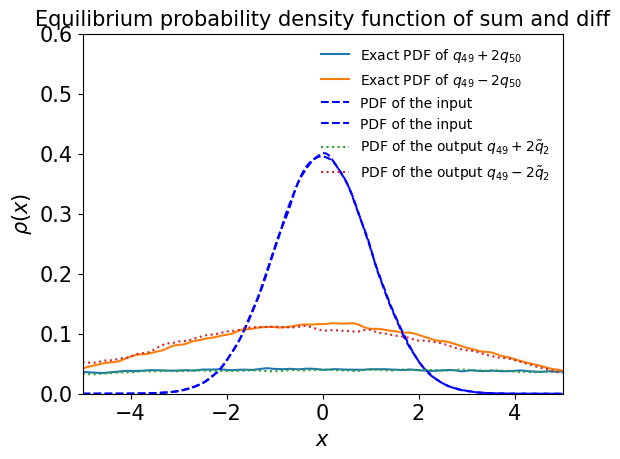

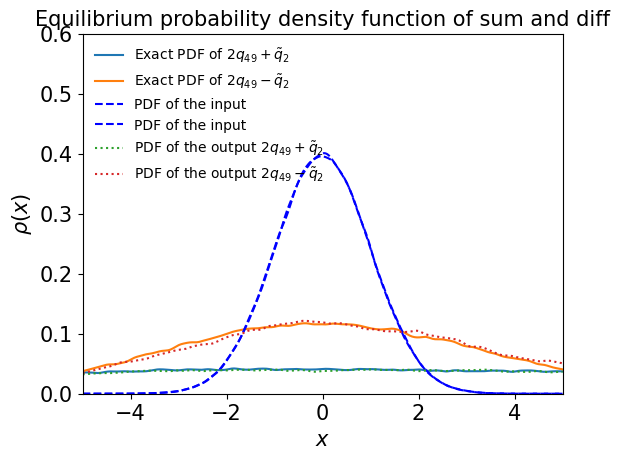

In [82]:
test3(model4)

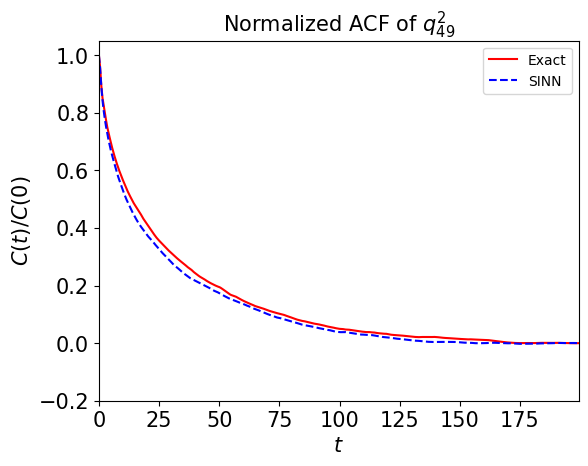

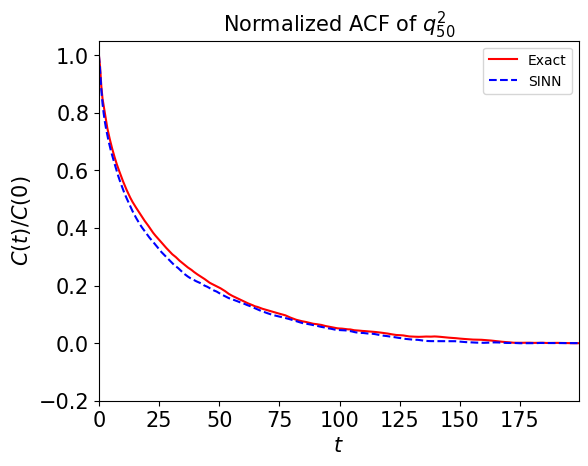

In [83]:
test4(model4)

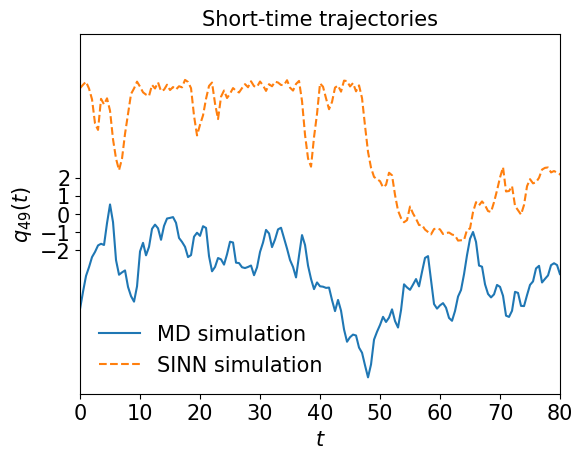

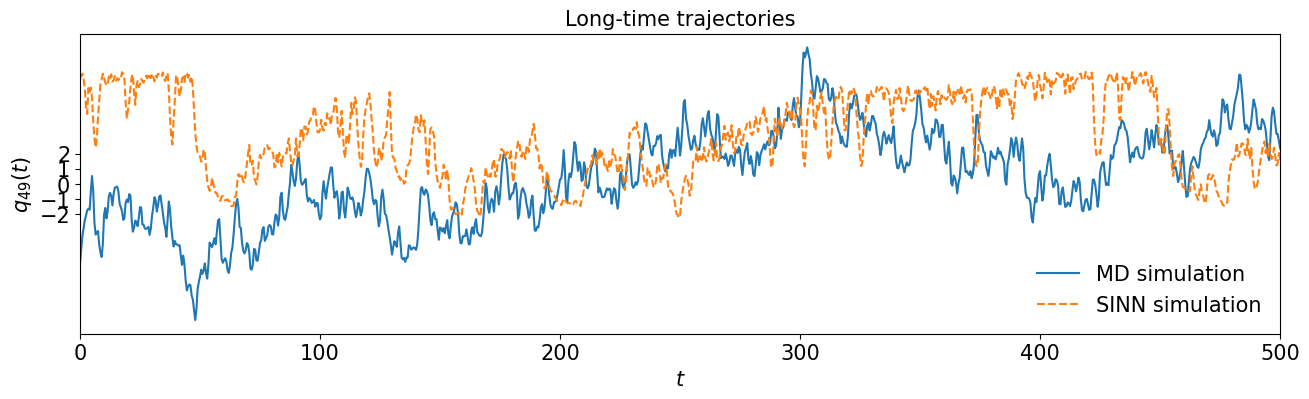

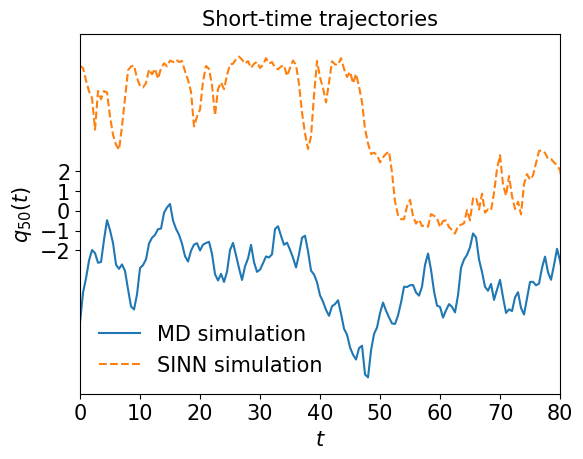

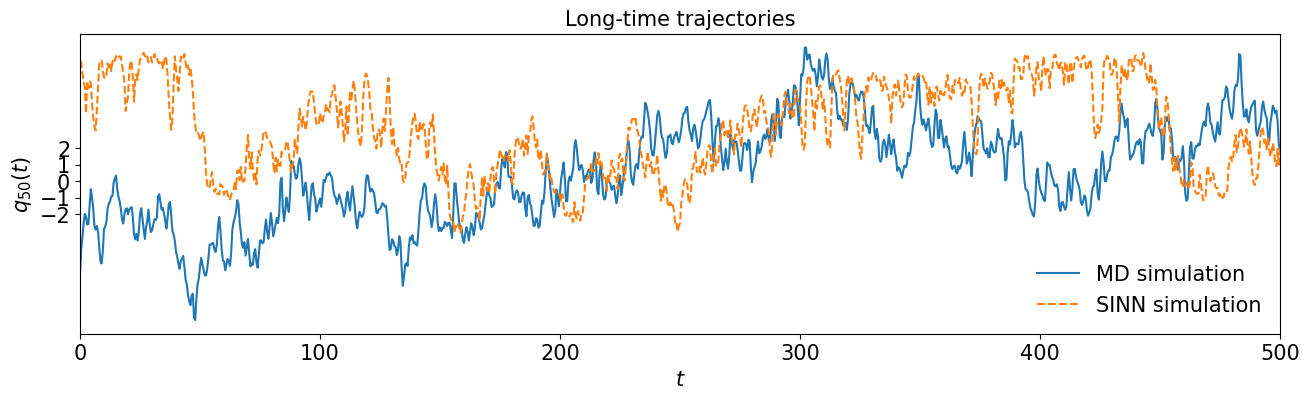

In [84]:
test5(model4)

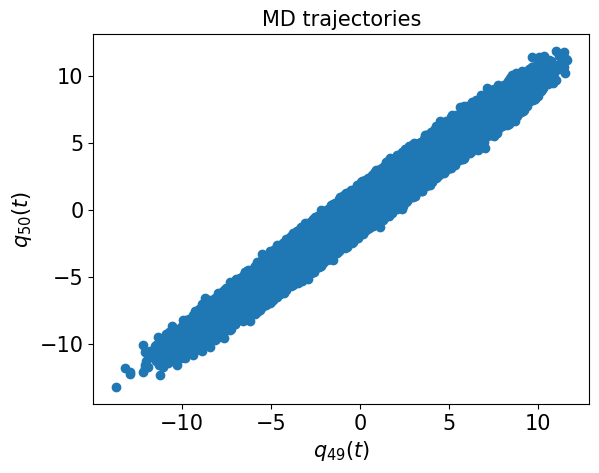

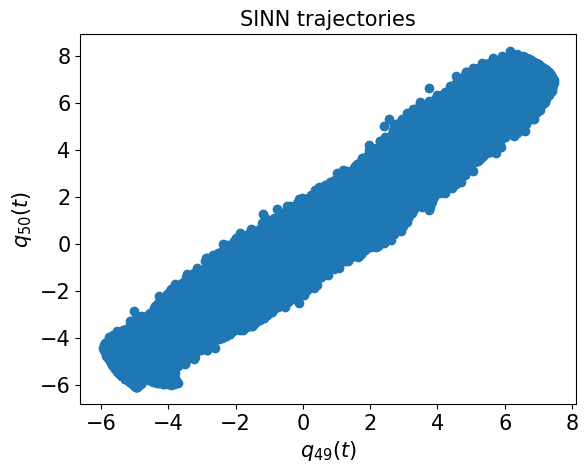

In [85]:
test6(model4)

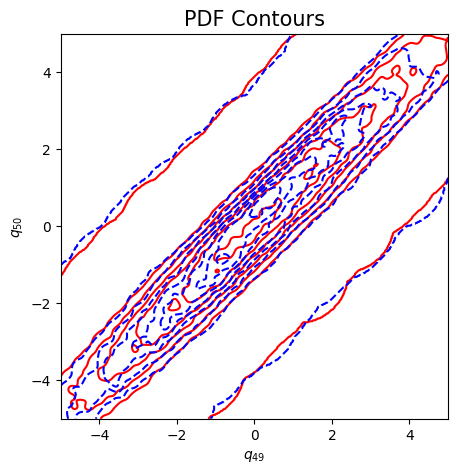

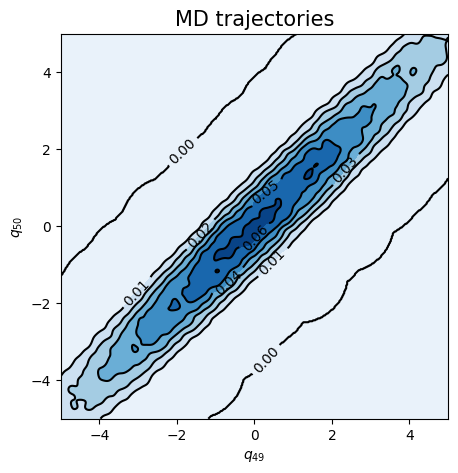

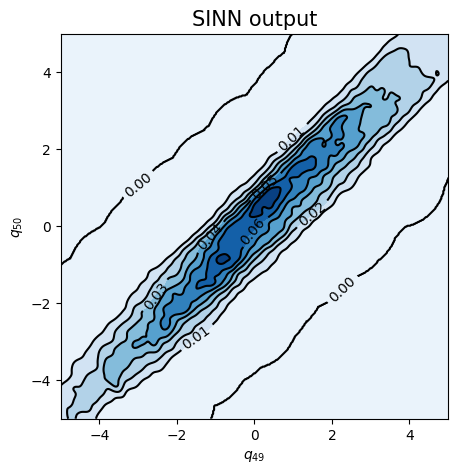

In [86]:
test7(model4)

In [87]:
### Defining SINN model
net5 = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

[0]-th step loss: 0.8389, 0.8321, acf: 0.09731, ccf: 0.11087, pdf: 0.29309, pdf2: 0.28972, acf2: 0.04106
[50]-th step loss: 0.1336, 0.1205, acf: 0.03824, ccf: 0.03821, pdf: 0.02125, pdf2: 0.01265, acf2: 0.01017
[100]-th step loss: 0.1023, 0.1057, acf: 0.03759, ccf: 0.03774, pdf: 0.01330, pdf2: 0.00757, acf2: 0.00955
[150]-th step loss: 0.0914, 0.0765, acf: 0.02055, ccf: 0.02053, pdf: 0.01959, pdf2: 0.01404, acf2: 0.00175
[200]-th step loss: 0.0276, 0.0217, acf: 0.00761, ccf: 0.00758, pdf: 0.00304, pdf2: 0.00311, acf2: 0.00039
[250]-th step loss: 0.0538, 0.0408, acf: 0.01380, ccf: 0.01376, pdf: 0.00763, pdf2: 0.00505, acf2: 0.00056
[300]-th step loss: 0.0152, 0.0177, acf: 0.00572, ccf: 0.00570, pdf: 0.00365, pdf2: 0.00236, acf2: 0.00023
[350]-th step loss: 0.0166, 0.0107, acf: 0.00426, ccf: 0.00424, pdf: 0.00103, pdf2: 0.00081, acf2: 0.00038
[400]-th step loss: 0.0258, 0.0660, acf: 0.03159, ccf: 0.03140, pdf: 0.00047, pdf2: 0.00129, acf2: 0.00121
[450]-th step loss: 0.0444, 0.0679, acf:

[3850]-th step loss: 0.2414, 0.2426, acf: 0.10371, ccf: 0.10346, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03546
[3900]-th step loss: 0.2137, 0.2129, acf: 0.09467, ccf: 0.09445, pdf: 0.00001, pdf2: 0.00001, acf2: 0.02380
[3950]-th step loss: 0.2433, 0.2427, acf: 0.10397, ccf: 0.10371, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03503
[4000]-th step loss: 0.2583, 0.2535, acf: 0.10803, ccf: 0.10776, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03766
[4050]-th step loss: 0.2719, 0.2719, acf: 0.11221, ccf: 0.11193, pdf: 0.00000, pdf2: 0.00000, acf2: 0.04776
[4100]-th step loss: 0.2642, 0.2659, acf: 0.11044, ccf: 0.11016, pdf: 0.00000, pdf2: 0.00000, acf2: 0.04525
[4150]-th step loss: 0.2527, 0.2501, acf: 0.10510, ccf: 0.10483, pdf: 0.00000, pdf2: 0.00000, acf2: 0.04020
[4200]-th step loss: 0.2572, 0.2573, acf: 0.10765, ccf: 0.10738, pdf: 0.00000, pdf2: 0.00000, acf2: 0.04228
[4250]-th step loss: 0.2354, 0.2335, acf: 0.09940, ccf: 0.09916, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03491
[4300]-th step loss: 0.1937,

[7650]-th step loss: 0.2862, 0.2869, acf: 0.11365, ccf: 0.11343, pdf: 0.00417, pdf2: 0.00145, acf2: 0.05420
[7700]-th step loss: 0.2866, 0.2868, acf: 0.11366, ccf: 0.11344, pdf: 0.00409, pdf2: 0.00143, acf2: 0.05420
[7750]-th step loss: 0.2865, 0.2868, acf: 0.11368, ccf: 0.11345, pdf: 0.00402, pdf2: 0.00141, acf2: 0.05420
[7800]-th step loss: 0.2864, 0.2867, acf: 0.11369, ccf: 0.11347, pdf: 0.00395, pdf2: 0.00139, acf2: 0.05419
[7850]-th step loss: 0.2863, 0.2866, acf: 0.11371, ccf: 0.11348, pdf: 0.00388, pdf2: 0.00138, acf2: 0.05419
[7900]-th step loss: 0.2865, 0.2866, acf: 0.11373, ccf: 0.11350, pdf: 0.00382, pdf2: 0.00136, acf2: 0.05419
[7950]-th step loss: 0.2859, 0.2865, acf: 0.11374, ccf: 0.11351, pdf: 0.00376, pdf2: 0.00135, acf2: 0.05418
[8000]-th step loss: 0.2863, 0.2865, acf: 0.11376, ccf: 0.11353, pdf: 0.00371, pdf2: 0.00133, acf2: 0.05418
[8050]-th step loss: 0.2866, 0.2865, acf: 0.11377, ccf: 0.11354, pdf: 0.00366, pdf2: 0.00132, acf2: 0.05418
[8100]-th step loss: 0.2857,

[11450]-th step loss: 0.2735, 0.2740, acf: 0.11093, ccf: 0.11069, pdf: 0.00013, pdf2: 0.00002, acf2: 0.05225
[11500]-th step loss: 0.2737, 0.2738, acf: 0.11088, ccf: 0.11064, pdf: 0.00012, pdf2: 0.00002, acf2: 0.05217
[11550]-th step loss: 0.2740, 0.2737, acf: 0.11083, ccf: 0.11059, pdf: 0.00012, pdf2: 0.00002, acf2: 0.05213
[11600]-th step loss: 0.2741, 0.2735, acf: 0.11079, ccf: 0.11055, pdf: 0.00011, pdf2: 0.00002, acf2: 0.05207
[11650]-th step loss: 0.2735, 0.2734, acf: 0.11076, ccf: 0.11051, pdf: 0.00011, pdf2: 0.00002, acf2: 0.05202
[11700]-th step loss: 0.2735, 0.2733, acf: 0.11072, ccf: 0.11048, pdf: 0.00010, pdf2: 0.00002, acf2: 0.05197
[11750]-th step loss: 0.2737, 0.2732, acf: 0.11069, ccf: 0.11045, pdf: 0.00010, pdf2: 0.00001, acf2: 0.05193
[11800]-th step loss: 0.2731, 0.2731, acf: 0.11069, ccf: 0.11045, pdf: 0.00009, pdf2: 0.00001, acf2: 0.05186
[11850]-th step loss: 0.2721, 0.2730, acf: 0.11066, ccf: 0.11042, pdf: 0.00009, pdf2: 0.00001, acf2: 0.05183
[11900]-th step los

[15250]-th step loss: 0.2710, 0.2709, acf: 0.11019, ccf: 0.10997, pdf: 0.00002, pdf2: 0.00000, acf2: 0.05072
[15300]-th step loss: 0.2716, 0.2708, acf: 0.11014, ccf: 0.10992, pdf: 0.00002, pdf2: 0.00000, acf2: 0.05073
[15350]-th step loss: 0.2718, 0.2716, acf: 0.11051, ccf: 0.11029, pdf: 0.00002, pdf2: 0.00000, acf2: 0.05075
[15400]-th step loss: 0.2723, 0.2718, acf: 0.11058, ccf: 0.11037, pdf: 0.00002, pdf2: 0.00000, acf2: 0.05085
[15450]-th step loss: 0.2718, 0.2718, acf: 0.11050, ccf: 0.11028, pdf: 0.00002, pdf2: 0.00000, acf2: 0.05102
[15500]-th step loss: 0.2725, 0.2714, acf: 0.11032, ccf: 0.11010, pdf: 0.00002, pdf2: 0.00000, acf2: 0.05094
[15550]-th step loss: 0.2724, 0.2714, acf: 0.11033, ccf: 0.11011, pdf: 0.00002, pdf2: 0.00000, acf2: 0.05093
[15600]-th step loss: 0.2708, 0.2714, acf: 0.11030, ccf: 0.11009, pdf: 0.00002, pdf2: 0.00000, acf2: 0.05098
[15650]-th step loss: 0.2717, 0.2712, acf: 0.11027, ccf: 0.11006, pdf: 0.00002, pdf2: 0.00000, acf2: 0.05087
[15700]-th step los

KeyboardInterrupt: 

In [ ]:
draw_loss(model5)

In [ ]:
draw_errors(model5)

In [ ]:
draw_adaptive_w(model5)
draw_epoch_w(model5)

In [ ]:
test1(model5)

In [ ]:
test2(model5)

In [ ]:
test3(model5)

In [ ]:
test4(model5)

In [ ]:
test5(model5)

In [ ]:
test6(model5)

In [ ]:
test7(model5)

In [ ]:
### Defining SINN model
net6 = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

In [ ]:
draw_loss(model6)

In [ ]:
draw_errors(model6)

In [ ]:
draw_adaptive_w(model6)
draw_epoch_w(model6)

In [ ]:
test1(model6)

In [ ]:
test2(model6)

In [ ]:
test3(model6)

In [ ]:
test4(model6)

In [ ]:
test5(model6)

In [ ]:
test6(model6)

In [ ]:
test7(model6)

In [ ]:
### Defining SINN model
net7 = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

In [ ]:
draw_loss(model7)

In [ ]:
draw_errors(model7)

In [ ]:
draw_adaptive_w(model7)
draw_epoch_w(model7)

In [ ]:
test1(model7)

In [ ]:
test2(model7)

In [ ]:
test3(model7)

In [ ]:
test4(model7)

In [ ]:
test5(model7)

In [ ]:
test6(model7)

In [ ]:
test7(model7)

In [ ]:
### Defining SINN model
net8 = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

In [ ]:
draw_loss(model8)

In [ ]:
draw_errors(model8)

In [ ]:
draw_adaptive_w(model8)
draw_epoch_w(model8)

In [ ]:
test1(model8)

In [ ]:
test2(model8)

In [ ]:
test3(model8)

In [ ]:
test4(model8)

In [ ]:
test5(model8)

In [ ]:
test6(model8)

In [ ]:
test7(model8)

In [ ]:
### Defining SINN model
net9 = SINN(2, 100, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()

In [ ]:
draw_loss(model9)

In [ ]:
draw_errors(model9)

In [ ]:
draw_adaptive_w(model9)
draw_epoch_w(model9)

In [ ]:
test1(model9)

In [ ]:
test2(model9)

In [ ]:
test3(model9)

In [ ]:
test4(model9)

In [ ]:
test5(model9)

In [ ]:
test6(model9)

In [ ]:
test7(model9)